# Проект по ВКИАД
## Кузьмицкий Владимир
#### 13.12.2020

### В качестве темы для исследования я решил выбрать установление корреляции между географическим положением населённых городов Беларуси и структурой их названий. Ещё в начальной школе мне сказали, что в разных областях Беларуси можно проследить, какой город южнее (ближе к Украине) или восточнее (ближе к России), соответственно и Западнее/Севернее. В пример приводили какие-то отдельные названия городов и говорили что-то вроде "так много российских городов называется" или "звучит более украински".  И вот я выбрал это темой моего небольшого проектика, решив выяснить, действительно ли города различных регионов Беларуси также различаются в окончаниях своих названий.



### Итак, первый этап состоит в том, чтобы найти данные о городах Беларуси. Я, не мудрствуя лукаво, полез на логичный для этого домен 

[opendata.by](https://opendata.by/)

### Там я нашёл замечательный датасет с информацией, о городах Беларуси. Вот так выглядит скриншот из excel [с этими данными](https://opendata.by/node/480), которые, если верить составителям, актуальны на 2017 год.

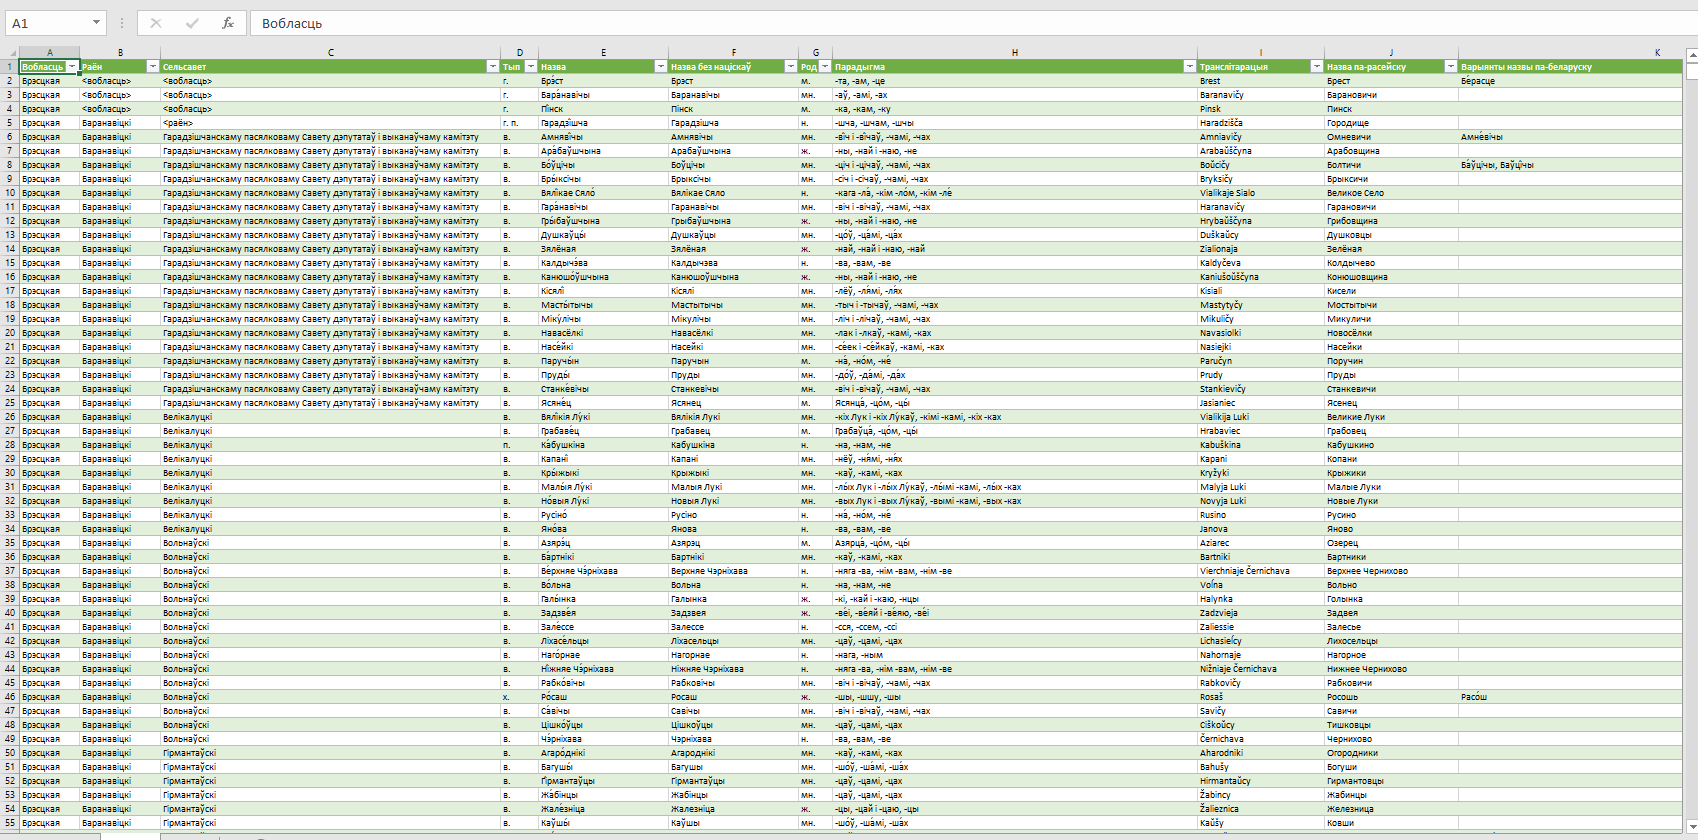

### В самом деле выглядит неплохо...тут почти 24 тысячи позиций! Я и не думал, что в нашей прекрасной стране может быть так много населённых пунктов. Только вот есть два маленьких недостатка этого набора данных в рамках решения моей задачи.

### * Во-первых, тут присутствует лишняя информация, которую, в целях экономии времени, я бы убрал.
### * Во-вторых, тут не указаны географические координаты населённых пунктов, надо бы ещё откуда-то их достать.

### Решение первого подпункта довольно очевидно: удаляем ненужные столбцы прямо в MS excel :)

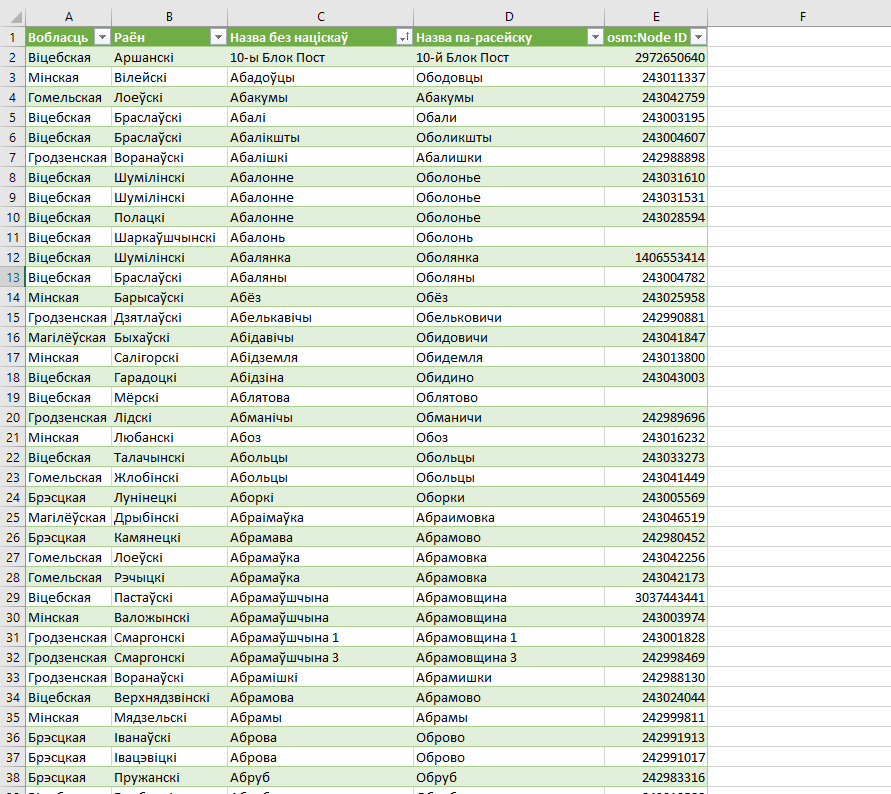

### Я оставил только колонки "вобласць", "раён", "назва па-беларуску", "назва па-расейску" и "osm: node ID". А ещё сохранил это всё в csv формате как punkty_belarusi_cleaned_1.csv

### "Что такое node ID?" спросите вы? А я отвечу: это идентификационный номер элемента местности в системе [Open Street Maps](https://www.openstreetmap.org/)

### C помощью этого номера можно получать информацию об объекте местности с использованием Open Street Maps API. Среди прочего, простым http запросом можно получить информацию и о широте/долготе населённого пункта, что и хочется мне сделать.

### Пришло время побаловаться с python: давайте получим информацию о городе Минск по вышеуказанной схеме.

In [219]:
import requests as req

print(req.get("https://api.openstreetmap.org/api/0.6/node/26162465").text)

<?xml version="1.0" encoding="UTF-8"?>
<osm version="0.6" generator="CGImap 0.8.3 (906934 spike-07.openstreetmap.org)" copyright="OpenStreetMap and contributors" attribution="http://www.openstreetmap.org/copyright" license="http://opendatacommons.org/licenses/odbl/1-0/">
 <node id="26162465" visible="true" version="156" changeset="90482230" timestamp="2020-09-06T14:22:58Z" user="Iváns" uid="7579660" lat="53.9023340" lon="27.5618791">
  <tag k="addr:country" v="BY"/>
  <tag k="addr:postcode" v="220000"/>
  <tag k="admin_level" v="2"/>
  <tag k="alt_name:be" v="Менск"/>
  <tag k="alt_name:gl" v="Мінск"/>
  <tag k="alt_name:vi" v="Minsk;Minxcơva"/>
  <tag k="capital" v="yes"/>
  <tag k="capital_ISO3166-1" v="yes"/>
  <tag k="ele" v="280"/>
  <tag k="int_name" v="Minsk"/>
  <tag k="is_in:continent" v="Europe"/>
  <tag k="is_in:country" v="Belarus"/>
  <tag k="is_in:country_code" v="BY"/>
  <tag k="name" v="Минск"/>
  <tag k="name:ar" v="مينسك"/>
  <tag k="name:ast" v="Minsk"/>
  <tag k="na

### Нас интересуют два указанных поля (на скриншоте выделены красным)

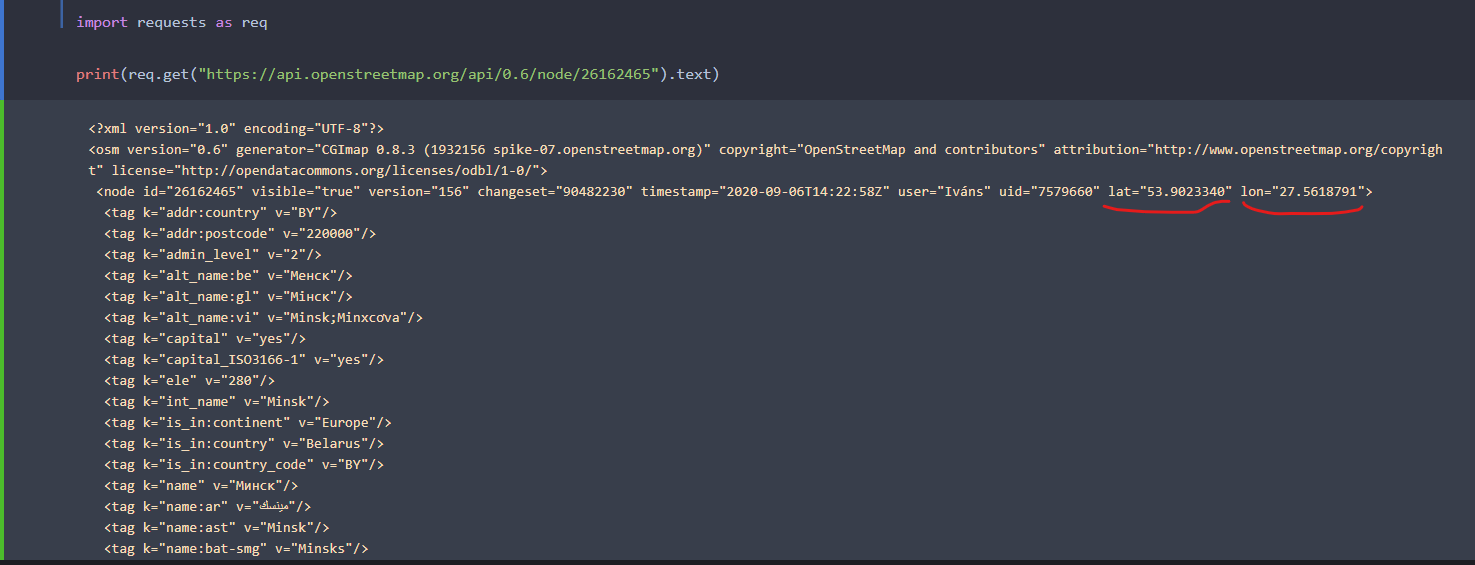

### Несложно догадаться, что получать интересующие нас значения можно с помощью регулярных выражений :) Осталось автоматизировать остальной процесс. Воспользуемся Pandas и загрузим очищенную версию данных как csv.

### Только сначала немножко поимпортим.

In [220]:
import pandas as pd
import numpy as np
import math
import re
import aiohttp
import asyncio
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from aiohttp import ClientSession
from collections import defaultdict

### Загружаем информацию о городах и очищаем её от тех позиций, для которых не удастся прочитать id, а также переименовываем колонки, чтобы код солиднее смотрелся.

In [221]:
data = pd.DataFrame(pd.read_csv("punkty_belarusi_cleaned_1.csv", sep=";"))
data = data[data['osm:Node ID'].notna()]
data = data.astype({"osm:Node ID": "int64"})
data = data.rename(columns={"Вобласць": "region", "Раён": "district", "Назва без націскаў": "blr_name", "Назва па-расейску": "rus_name", "osm:Node ID": "id"})
data

region     district    blr_name     rus_name         id
0      Брэсцкая   <вобласць>       Брэст        Брест   27171628
1      Брэсцкая   <вобласць>  Баранавічы   Барановичи  242978911
2      Брэсцкая   <вобласць>       Пінск        Пинск  242978912
3      Брэсцкая  Баранавіцкі  Гарадзішча     Городище  242979015
4      Брэсцкая  Баранавіцкі    Амнявічы     Омневичи  242992435
...         ...          ...         ...          ...        ...
23966   Мінская   Чэрвеньскі    Пятроўка     Петровка  243022922
23967   Мінская   Чэрвеньскі      Ратнае       Ратное  243025750
23968   Мінская   Чэрвеньскі  Стары Пруд  Старый Пруд  243022754
23969   Мінская   Чэрвеньскі       Хутар        Хутор  243022771
23970   Мінская   Чэрвеньскі     Юравічы      Юровичи  243022914

[23444 rows x 5 columns]

### Давайте попробуем для каждой указанной позиции получить ширину и долготу, а также сохранить их в две новые колонки

In [222]:
data["latitude"] = np.nan
data["longtitude"] = np.nan
data

region     district    blr_name     rus_name         id  latitude  \
0      Брэсцкая   <вобласць>       Брэст        Брест   27171628       NaN   
1      Брэсцкая   <вобласць>  Баранавічы   Барановичи  242978911       NaN   
2      Брэсцкая   <вобласць>       Пінск        Пинск  242978912       NaN   
3      Брэсцкая  Баранавіцкі  Гарадзішча     Городище  242979015       NaN   
4      Брэсцкая  Баранавіцкі    Амнявічы     Омневичи  242992435       NaN   
...         ...          ...         ...          ...        ...       ...   
23966   Мінская   Чэрвеньскі    Пятроўка     Петровка  243022922       NaN   
23967   Мінская   Чэрвеньскі      Ратнае       Ратное  243025750       NaN   
23968   Мінская   Чэрвеньскі  Стары Пруд  Старый Пруд  243022754       NaN   
23969   Мінская   Чэрвеньскі       Хутар        Хутор  243022771       NaN   
23970   Мінская   Чэрвеньскі     Юравічы      Юровичи  243022914       NaN   

       longtitude  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
23966         NaN  
23967         NaN  
23968         NaN  
23969         NaN  
23970         NaN  

[23444 rows x 7 columns]

### Наученный горьким опытом бесполезного ожидания (больше часа и всё зря!), я распараллелю процесс обработки запросов с помощью asyncio и aiohttp. Теперь всё занимает не более пары минуточек, но чуть подождать всё же придётся.

In [223]:
request_prefix_url = "https://api.openstreetmap.org/api/0.6/node/"
counter = 0
failed_counter = 0

def handle_coordinates(response, index):
    global data
    global failed_counter
    longtitude = re.findall(r"lon=\"(\d+\.\d+)\"", response)
    latitude = re.findall(r"lat=\"(\d+\.\d+)\"", response)
    if len(latitude) == 0 or len(longtitude) == 0:
#             print("Error on row " + str(index))
            failed_counter += 1
            return 
    data.at[index, "latitude"] = float(latitude[0])
    data.at[index, "longtitude"] = float(longtitude[0])

    
async def get_node_details(id, session):
    global counter
    url = request_prefix_url + id
    try:
        response = await session.request(method='GET', url=url)
        response.raise_for_status()
        counter += 1
#         print(counter)
    except Exception as err:
#         print(f"An error ocurred: {err}")
        pass
    return await response.text()


async def run_program(index, session):
    try:
        response = await get_node_details(str(data.at[index, "id"]), session)
        handle_coordinates(response, index)
    except Exception as err:
#         print(f"Exception occured__: {err}")
        pass
        

async with ClientSession() as session:
    await asyncio.gather(*[run_program(index, session) for index in data.index])

### Приведём чуть в порядок и сохраним

In [224]:
print("From: {}\nFailed: {}".format(counter, failed_counter))
data = data[data['latitude'].notna()]
data = data[data['longtitude'].notna()]
data.to_csv("punkty_belarusi_with_cooridnates.csv", sep=";")
data

From: 23225
Failed: 214


region     district    blr_name     rus_name         id   latitude  \
0      Брэсцкая   <вобласць>       Брэст        Брест   27171628  52.093751   
1      Брэсцкая   <вобласць>  Баранавічы   Барановичи  242978911  53.132292   
2      Брэсцкая   <вобласць>       Пінск        Пинск  242978912  52.111361   
3      Брэсцкая  Баранавіцкі  Гарадзішча     Городище  242979015  53.326824   
4      Брэсцкая  Баранавіцкі    Амнявічы     Омневичи  242992435  53.355020   
...         ...          ...         ...          ...        ...        ...   
23966   Мінская   Чэрвеньскі    Пятроўка     Петровка  243022922  53.694300   
23967   Мінская   Чэрвеньскі      Ратнае       Ратное  243025750  53.785280   
23968   Мінская   Чэрвеньскі  Стары Пруд  Старый Пруд  243022754  53.761984   
23969   Мінская   Чэрвеньскі       Хутар        Хутор  243022771  53.760812   
23970   Мінская   Чэрвеньскі     Юравічы      Юровичи  243022914  53.785000   

       longtitude  
0       23.685185  
1       26.018416  
2       26.102377  
3       26.005677  
4       25.902420  
...           ...  
23966   28.702980  
23967   28.748050  
23968   28.620105  
23969   28.684500  
23970   28.691109  

[23225 rows x 7 columns]

## Установление зависимости

### Первое, что приходит в голову, это посмотреть на среднее значение широты и долготы для пунктов с одинаковыми окончаниями. Давайте взглянем, какие они вообще бывают

In [225]:
def get_ending(word):
    return word[-2:]

data["blr_ending"] = ""
data["rus_ending"] = ""
for index in data.index:
    data.loc[index, "blr_ending"] =  get_ending(data.at[index, "blr_name"])
    data.loc[index, "rus_ending"] =  get_ending(data.at[index, "rus_name"])
data

region     district    blr_name     rus_name         id   latitude  \
0      Брэсцкая   <вобласць>       Брэст        Брест   27171628  52.093751   
1      Брэсцкая   <вобласць>  Баранавічы   Барановичи  242978911  53.132292   
2      Брэсцкая   <вобласць>       Пінск        Пинск  242978912  52.111361   
3      Брэсцкая  Баранавіцкі  Гарадзішча     Городище  242979015  53.326824   
4      Брэсцкая  Баранавіцкі    Амнявічы     Омневичи  242992435  53.355020   
...         ...          ...         ...          ...        ...        ...   
23966   Мінская   Чэрвеньскі    Пятроўка     Петровка  243022922  53.694300   
23967   Мінская   Чэрвеньскі      Ратнае       Ратное  243025750  53.785280   
23968   Мінская   Чэрвеньскі  Стары Пруд  Старый Пруд  243022754  53.761984   
23969   Мінская   Чэрвеньскі       Хутар        Хутор  243022771  53.760812   
23970   Мінская   Чэрвеньскі     Юравічы      Юровичи  243022914  53.785000   

       longtitude blr_ending rus_ending  
0       23.685185         ст         ст  
1       26.018416         чы         чи  
2       26.102377         ск         ск  
3       26.005677         ча         ще  
4       25.902420         чы         чи  
...           ...        ...        ...  
23966   28.702980         ка         ка  
23967   28.748050         ае         ое  
23968   28.620105         уд         уд  
23969   28.684500         ар         ор  
23970   28.691109         чы         чи  

[23225 rows x 9 columns]

In [226]:
def handle_endings(names):
    endings = defaultdict(lambda: 0)
    for name in names:
        ending = get_ending(name)
        endings[ending] += 1
    sorted_endings = sorted(endings.items(), key=lambda kv: kv[1], reverse=True)
    endings = dict([(key, value) for key, value in sorted_endings])
    return defaultdict(int, endings)

blr_endings = handle_endings(data["blr_name"])
print(blr_endings)
endings_data = pd.DataFrame(dict(blr_endings).items(), columns=["ending", "total"])
endings_data[:50]

defaultdict(<class 'int'>, {'кі': 3153, 'чы': 2261, 'ка': 2239, 'ва': 2074, 'на': 1930, 'цы': 986, 'ны': 825, 'ча': 619, 'ца': 401, 'ае': 369, 'ры': 322, 'ая': 319, 'да': 301, 'лі': 274, 'ец': 258, 'ты': 237, 'ле': 216, 'лы': 203, 'ня': 200, 'нь': 198, 'ок': 190, 'ды': 189, 'ні': 189, '’е': 184, 'ск': 179, 'шы': 173, 'аў': 168, ' 2': 162, ' 1': 158, 'ін': 154, 'ія': 137, 'ль': 136, 'це': 128, 'гі': 119, 'се': 118, 'не': 116, 'хі': 115, 'та': 111, 'ша': 105, 'ыя': 104, 'ын': 102, 'жа': 99, 'ра': 97, 'ор': 95, 'зе': 95, 'сы': 92, 'ое': 81, 'ці': 78, 'ло': 77, 'ік': 71, 'ўе': 67, 'вы': 66, 'но': 65, 'оў': 62, 'ля': 61, 'бы': 56, 'ак': 55, 'ар': 51, 'зы': 50, 'ць': 50, 'аі': 45, 'га': 40, 'мы': 38, 'эц': 37, 'зь': 37, 'ха': 37, 'ай': 37, 'зі': 36, 'цк': 36, 'жы': 36, 'ог': 35, 'ма': 33, 'пы': 33, 'еж': 31, 'ан': 30, 'ба': 29, 'ач': 29, 'ес': 29, 'од': 29, 'ла': 24, 'ст': 22, 'са': 21, 'ет': 20, 'сі': 20, 'па': 18, 'ал': 18, 'аг': 18, ' 3': 16, 'бр': 16, 'аж': 16, 'уд': 15, 'еі': 15, 'ея': 

ending  total
0      кі   3153
1      чы   2261
2      ка   2239
3      ва   2074
4      на   1930
5      цы    986
6      ны    825
7      ча    619
8      ца    401
9      ае    369
10     ры    322
11     ая    319
12     да    301
13     лі    274
14     ец    258
15     ты    237
16     ле    216
17     лы    203
18     ня    200
19     нь    198
20     ок    190
21     ды    189
22     ні    189
23     ’е    184
24     ск    179
25     шы    173
26     аў    168
27      2    162
28      1    158
29     ін    154
30     ія    137
31     ль    136
32     це    128
33     гі    119
34     се    118
35     не    116
36     хі    115
37     та    111
38     ша    105
39     ыя    104
40     ын    102
41     жа     99
42     ра     97
43     ор     95
44     зе     95
45     сы     92
46     ое     81
47     ці     78
48     ло     77
49     ік     71

### Теперь давайте посчитаем какую-нибудь абстрактную штуку вроде среднего значения широты для того или иного окончания и посмотрим, насколько действительно различаются эти показатели.

In [227]:
endings_data["average_latitude"] = 0.0
endings_data["average_longtitude"] = 0.0
endings_data

ending  total  average_latitude  average_longtitude
0       кі   3153               0.0                 0.0
1       чы   2261               0.0                 0.0
2       ка   2239               0.0                 0.0
3       ва   2074               0.0                 0.0
4       на   1930               0.0                 0.0
..     ...    ...               ...                 ...
224     ья      1               0.0                 0.0
225     ён      1               0.0                 0.0
226     юі      1               0.0                 0.0
227     Яр      1               0.0                 0.0
228     аб      1               0.0                 0.0

[229 rows x 4 columns]

In [228]:
for index in data.index:
#     print(index)
    ending = get_ending(data.at[index, "blr_name"])
    endings_data.loc[endings_data["ending"] == ending, "average_latitude"] += data.at[index, "latitude"]
    endings_data.loc[endings_data["ending"] == ending, "average_longtitude"] += data.at[index, "longtitude"]
for index in endings_data.index:
    endings_data.at[index, "average_latitude"] /= endings_data.at[index, "total"]
    endings_data.at[index, "average_longtitude"] /= endings_data.at[index, "total"]
endings_data

ending  total  average_latitude  average_longtitude
0       кі   3153         54.116258           27.397853
1       чы   2261         53.541833           27.176313
2       ка   2239         53.675438           28.807168
3       ва   2074         54.215526           28.233761
4       на   1930         54.270410           27.920103
..     ...    ...               ...                 ...
224     ья      1         54.416310           27.291410
225     ён      1         54.374682           28.874564
226     юі      1         53.854980           27.309780
227     Яр      1         53.602551           28.048780
228     аб      1         53.807170           28.596730

[229 rows x 4 columns]

### Так не очень понятно, что к чему, давайте используем min-max feature scaling

In [229]:
data["scaled_latitude"] = np.nan
data["scaled_longtitude"] = np.nan

min_latitude = data["latitude"].min()
max_latitude = data["latitude"].max()
latitude_delta = max_latitude - min_latitude
min_longtitude = data["longtitude"].min()
max_longtitude = data["longtitude"].max()
longtitude_delta = max_longtitude - min_longtitude

for index in data.index:
#     print(index)
    data.at[index, "scaled_latitude"] = (data.at[index, "latitude"] - min_latitude) / latitude_delta
    data.at[index, "scaled_longtitude"] = (data.at[index, "longtitude"] - min_longtitude) / longtitude_delta
data


region     district    blr_name     rus_name         id   latitude  \
0      Брэсцкая   <вобласць>       Брэст        Брест   27171628  52.093751   
1      Брэсцкая   <вобласць>  Баранавічы   Барановичи  242978911  53.132292   
2      Брэсцкая   <вобласць>       Пінск        Пинск  242978912  52.111361   
3      Брэсцкая  Баранавіцкі  Гарадзішча     Городище  242979015  53.326824   
4      Брэсцкая  Баранавіцкі    Амнявічы     Омневичи  242992435  53.355020   
...         ...          ...         ...          ...        ...        ...   
23966   Мінская   Чэрвеньскі    Пятроўка     Петровка  243022922  53.694300   
23967   Мінская   Чэрвеньскі      Ратнае       Ратное  243025750  53.785280   
23968   Мінская   Чэрвеньскі  Стары Пруд  Старый Пруд  243022754  53.761984   
23969   Мінская   Чэрвеньскі       Хутар        Хутор  243022771  53.760812   
23970   Мінская   Чэрвеньскі     Юравічы      Юровичи  243022914  53.785000   

       longtitude blr_ending rus_ending  scaled_latitude  scaled_longtitude  
0       23.685185         ст         ст         0.165041           0.049754  
1       26.018416         чы         чи         0.379489           0.294650  
2       26.102377         ск         ск         0.168677           0.303463  
3       26.005677         ча         ще         0.419658           0.293313  
4       25.902420         чы         чи         0.425480           0.282475  
...           ...        ...        ...              ...                ...  
23966   28.702980         ка         ка         0.495538           0.576422  
23967   28.748050         ае         ое         0.514324           0.581153  
23968   28.620105         уд         уд         0.509514           0.567723  
23969   28.684500         ар         ор         0.509272           0.574482  
23970   28.691109         чы         чи         0.514266           0.575176  

[23225 rows x 11 columns]

### А теперь давайте проведём небольшую визуализацию происходящего с использованием matplotlib. Для начала напишем вот такой непримечательный блок кода.

In [230]:
plt.rcParams.update({'font.size': 22,
                     'text.color' : "black",
                     'axes.labelcolor' : "orange"})

POINTS_IN_CURVES = 315
STROKE_WIDTH = 2.5
MARKER_SIZE = 9.0
FIGURE_SIZE = 25


TICKS_FONT_SIZE = 20.0
AXES_TICK_COLOR = "orange"

def prepare_plot():
    figure = plt.figure(figsize=(FIGURE_SIZE, FIGURE_SIZE))
    ax = plt.gca()
    ax.set_xlabel("Longtitude")
    ax.set_ylabel("Latitude")
    ax.tick_params(axis="both", width=5, length=10, direction="inout", color=AXES_TICK_COLOR)
    plt.xticks(fontsize=TICKS_FONT_SIZE, color=AXES_TICK_COLOR)
    plt.yticks(fontsize=TICKS_FONT_SIZE, color=AXES_TICK_COLOR)
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)


def filtered_plot(drawing_data, function, classes, showlegend=True):  
    plt.close()
    prepare_plot()
    number_of_classes = len(classes)
    number_of_points = len(drawing_data)
    x=[[] for i in range(number_of_classes)]
    y=[[] for i in range(number_of_classes)]
    for index in drawing_data.index:
        result = function(drawing_data.at[index, "blr_name"])
        if result not in classes:
            continue        
        result_index = classes.index(result)
        x[result_index].append(drawing_data.at[index, "scaled_longtitude"])
        y[result_index].append(drawing_data.at[index, "scaled_latitude"])
    x_np = np.array([np.array(i) for i in x], dtype=object)
    y_np = np.array([np.array(i) for i in y], dtype=object)
    for i in range(number_of_classes):
        if len(x_np[i] > 0):
            plt.scatter(x_np[i], y_np[i], 30.0, alpha=0.8, label=classes[i])
    if showlegend:
        plt.legend()
    plt.show()

### Теперь построим карту, которая будем иллюстрировать распределение городов на территории нашей страны в зависимости от двух последних букв в окончании. Для наглядности пока возьмём 5 самых распространённых, но никто не мешает с этим делом поиграться. 

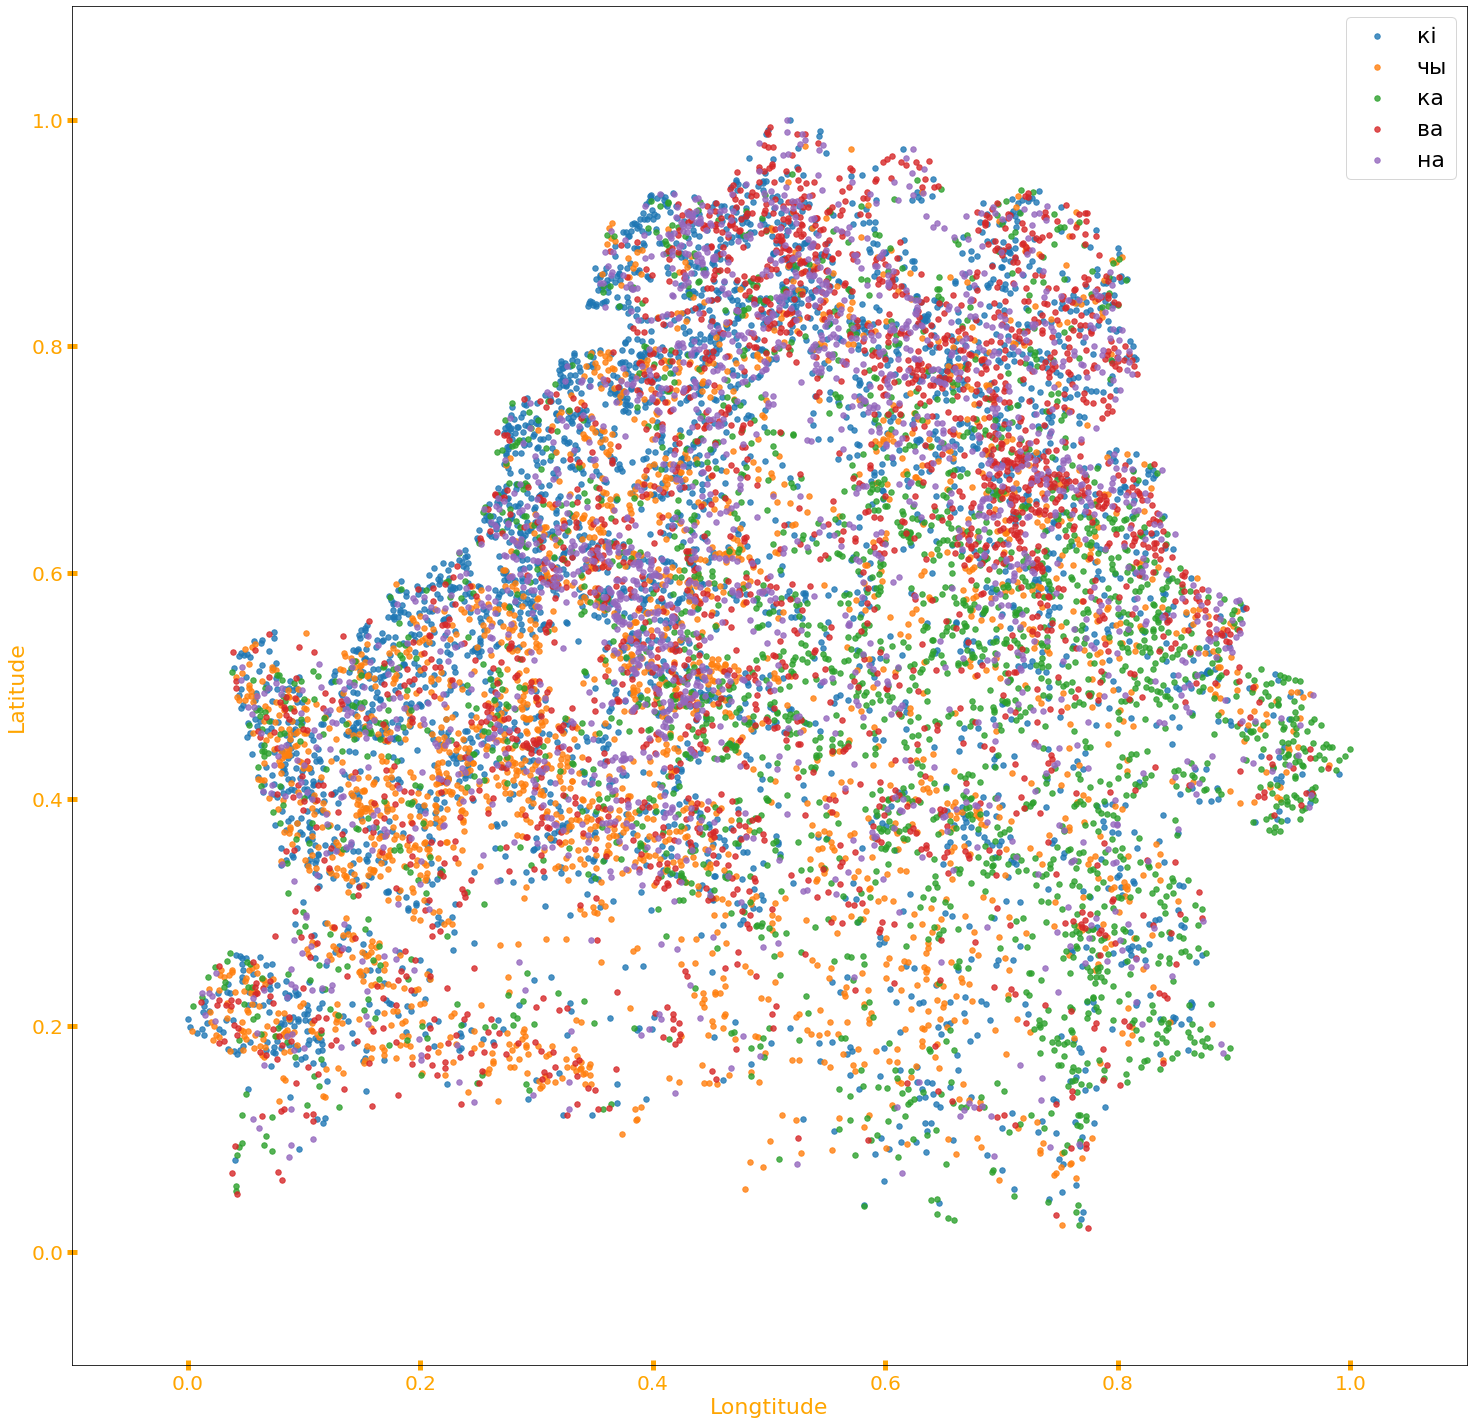

In [231]:
drawing_data = data.sample(frac=1).reset_index(drop=True)
drawing_endings = list(blr_endings.keys())[:5]
filtered_plot(drawing_data, get_ending, drawing_endings)

### Пока приведём субъктивно-визуальную оценку: явно можно выделить "более зелёный" регион у российских границ, "более красный" у латвийских границ, "более синий" у литовских и "рыженькое уплотнение" у польских. Возможно, дело в плотности городов, но всё ещё раскрас довольно дифференцированный получается.

### Как я уже говорил, можно построить карту по отдельному окончанию. Смотрите, как устроено распределение по окончанию "цы"

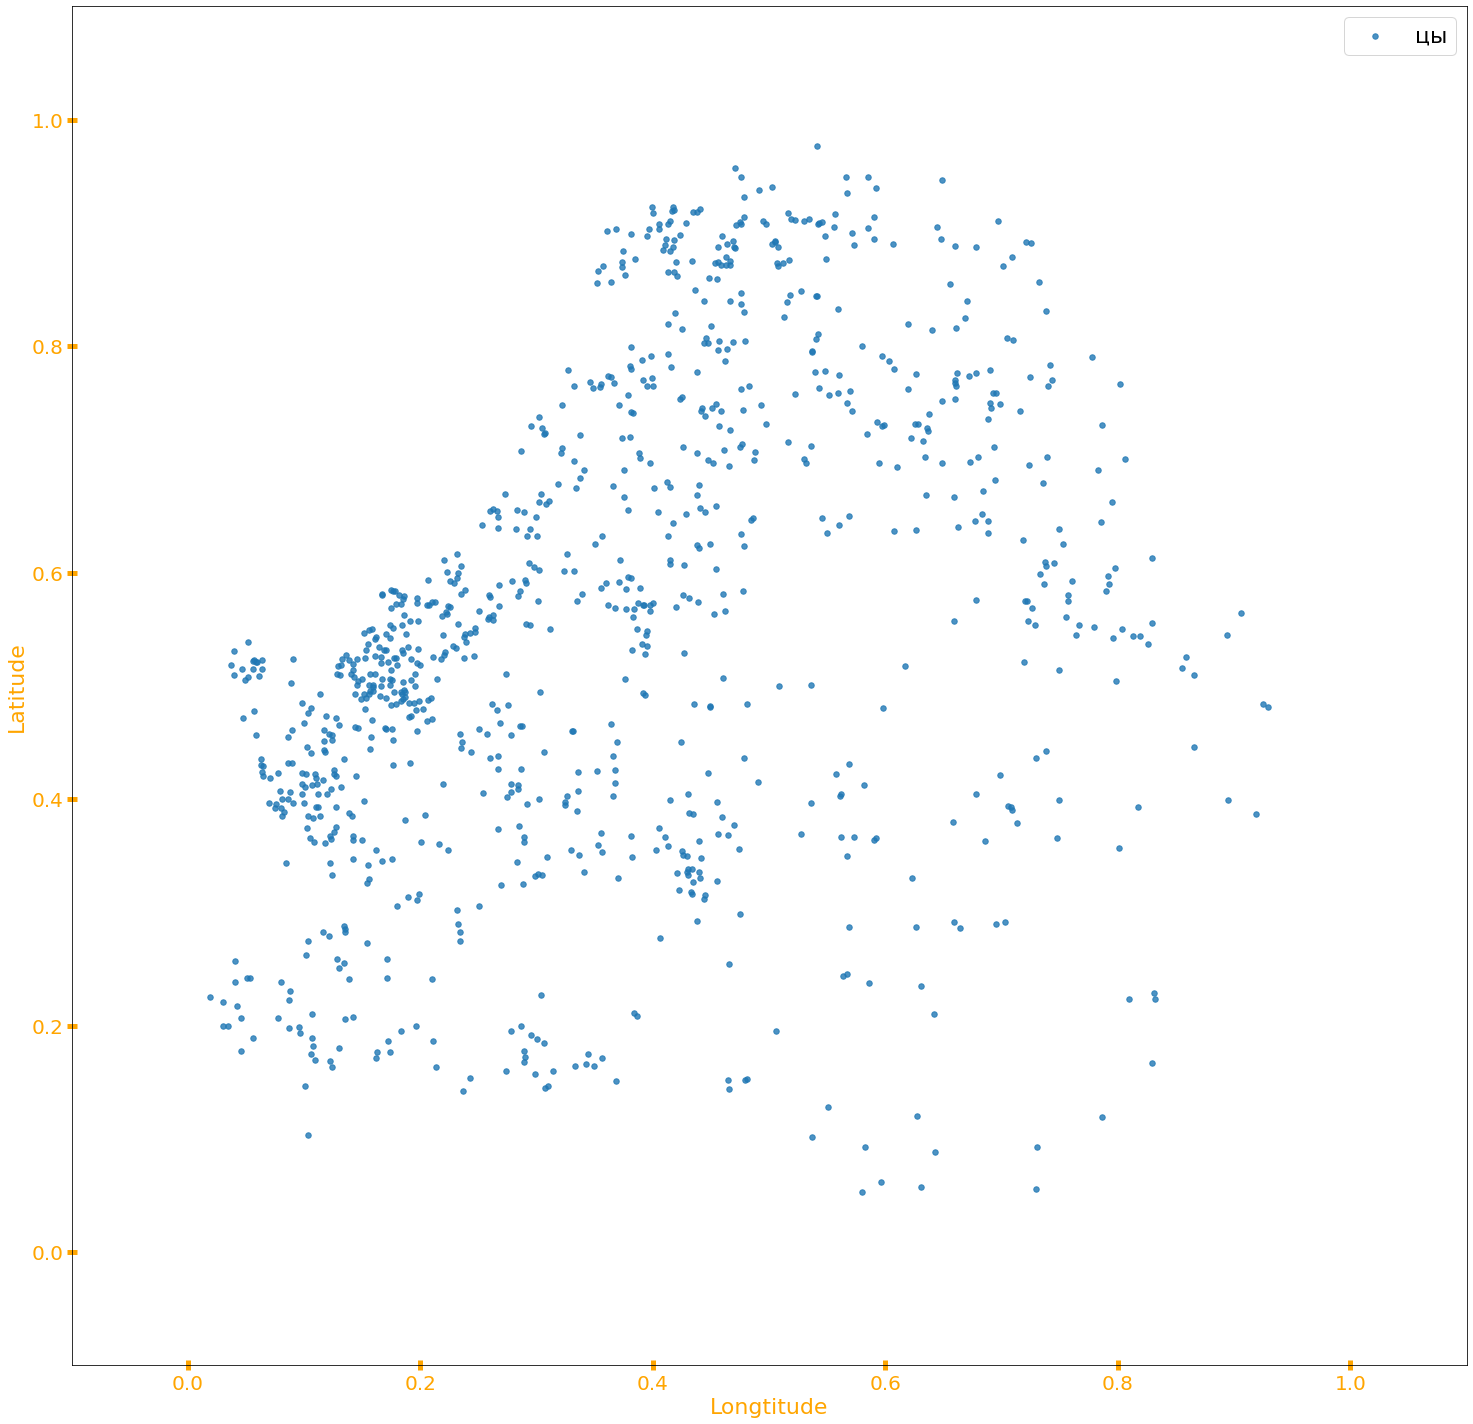

In [232]:
filtered_plot(drawing_data, get_ending, ["цы"])

### Вновь визуально получаем уплотнение на границе с Литвой. Забавненько

### Давайте выделим "победителей"

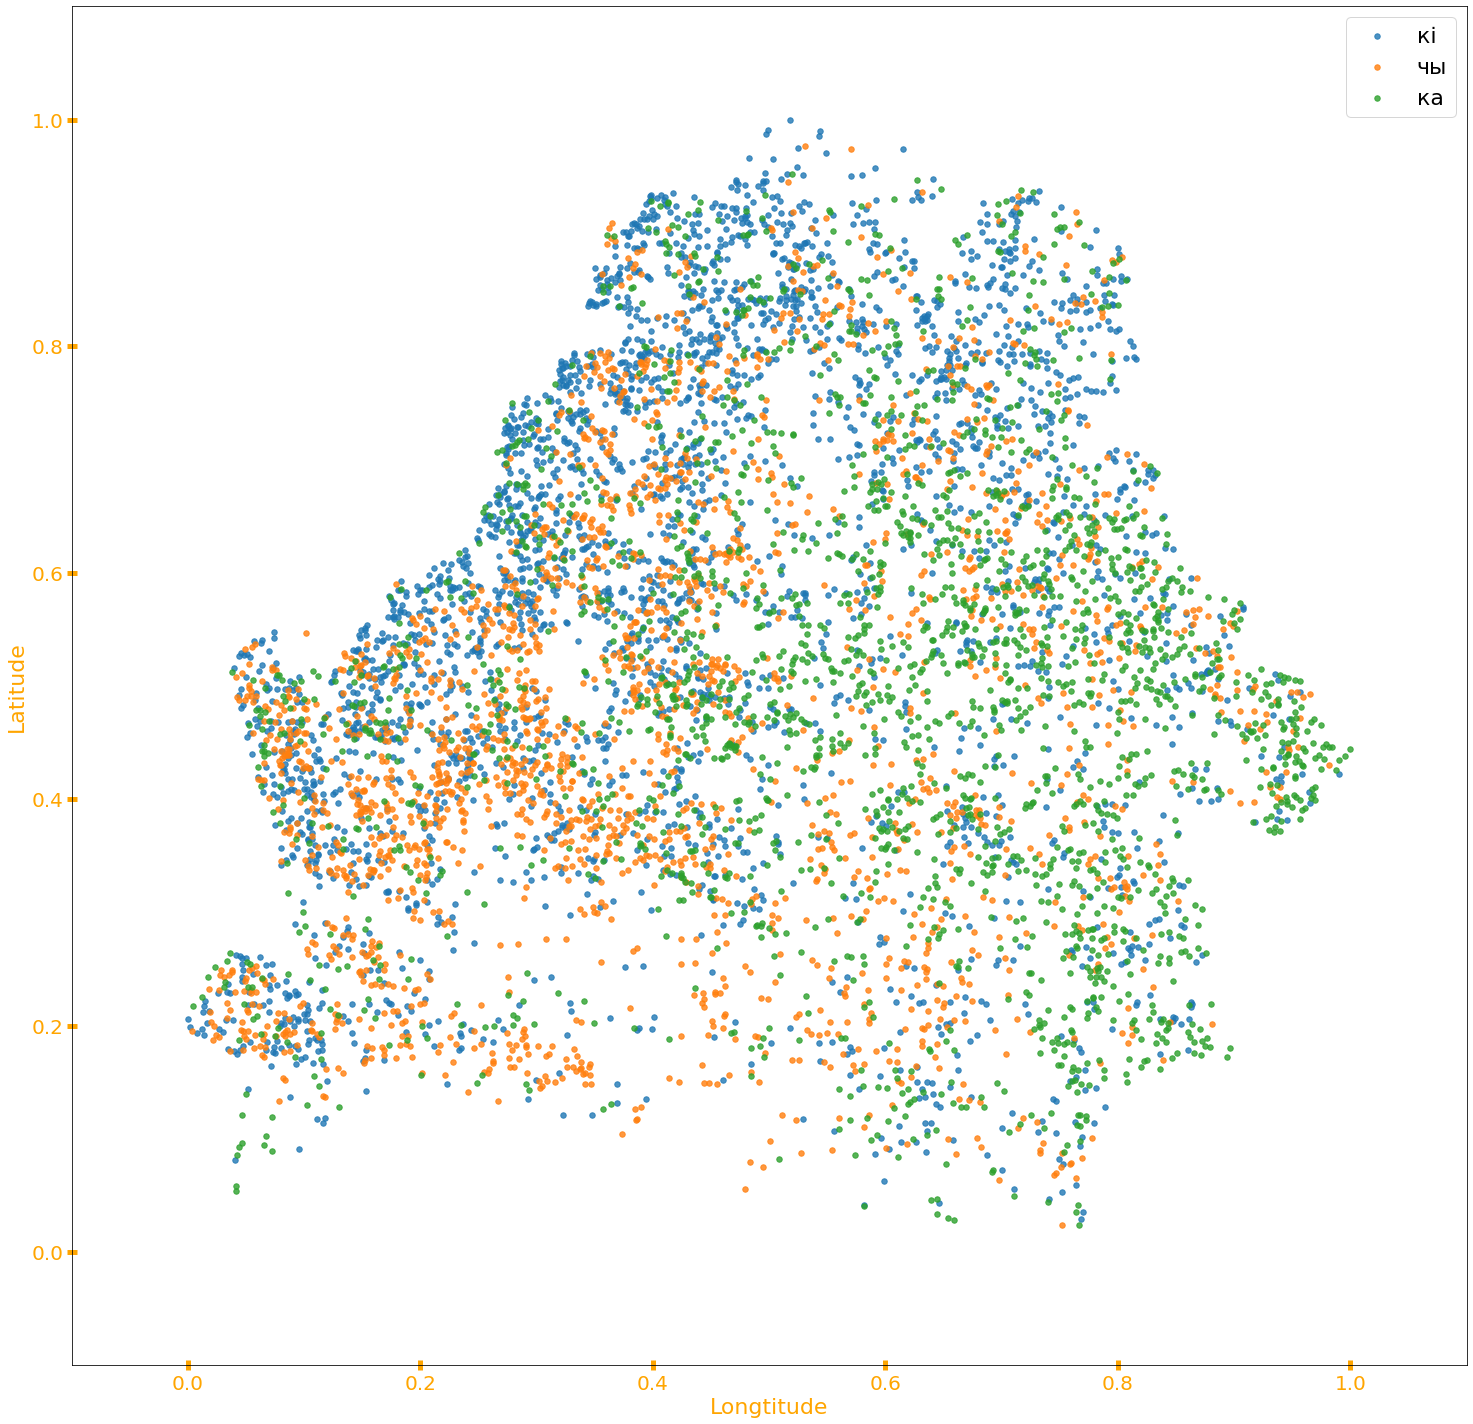

In [233]:
filtered_plot(drawing_data, get_ending, ["кі", "чы", "ка"])

### У Польши "начыкано" больше :)

### Вновь же, пока всё сугубо визуально

### Давайте просто бахнем сразу все города. Получим прдеставление о плотности городов в Беларуси...согласно датасету)

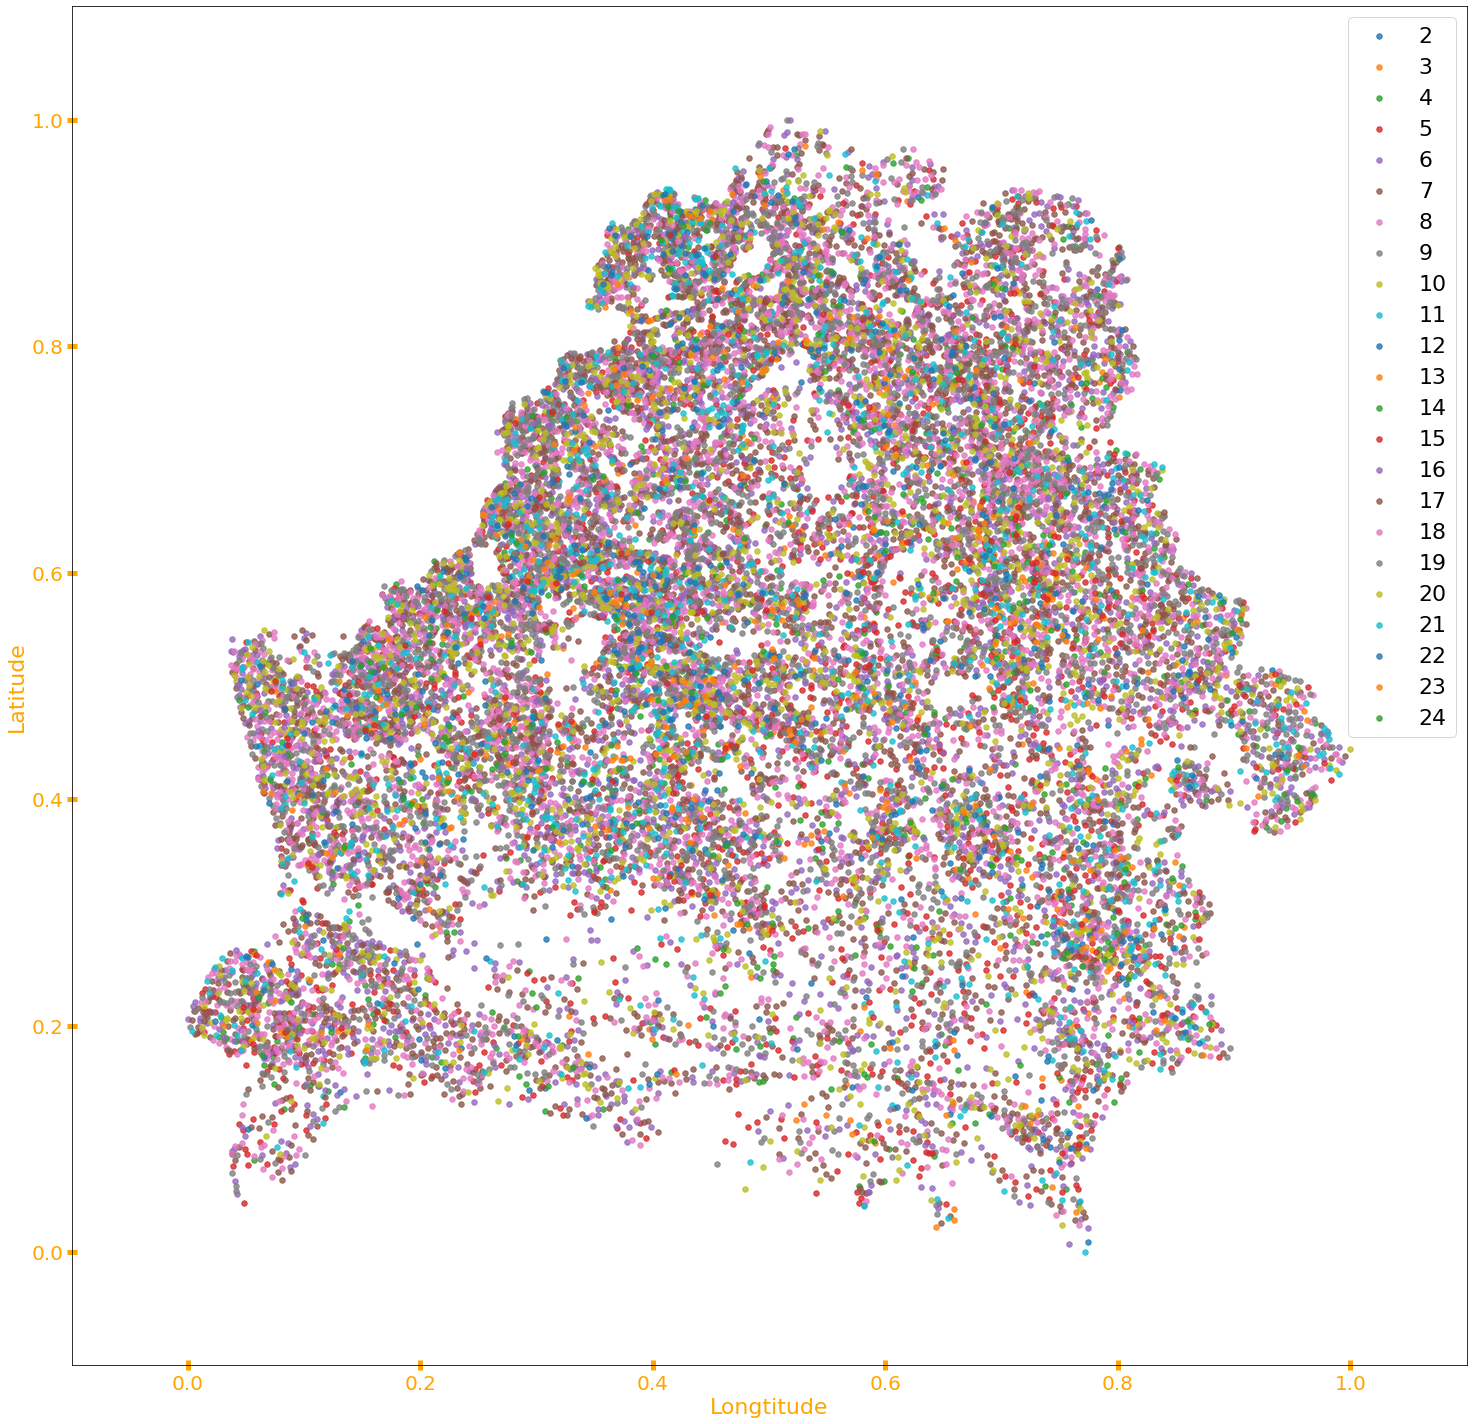

In [234]:
# для любителей экстрима
filtered_plot(drawing_data, len, range(30))

### Внимательный читатель заметит, что написанная мной функция может принимать не только окончания, но и любые другие уместные функции для анализа. Давайте посмотрим, где больше всего белорусы нашипилявили.

In [235]:
def get_sh(word):
    return word.count("ш")

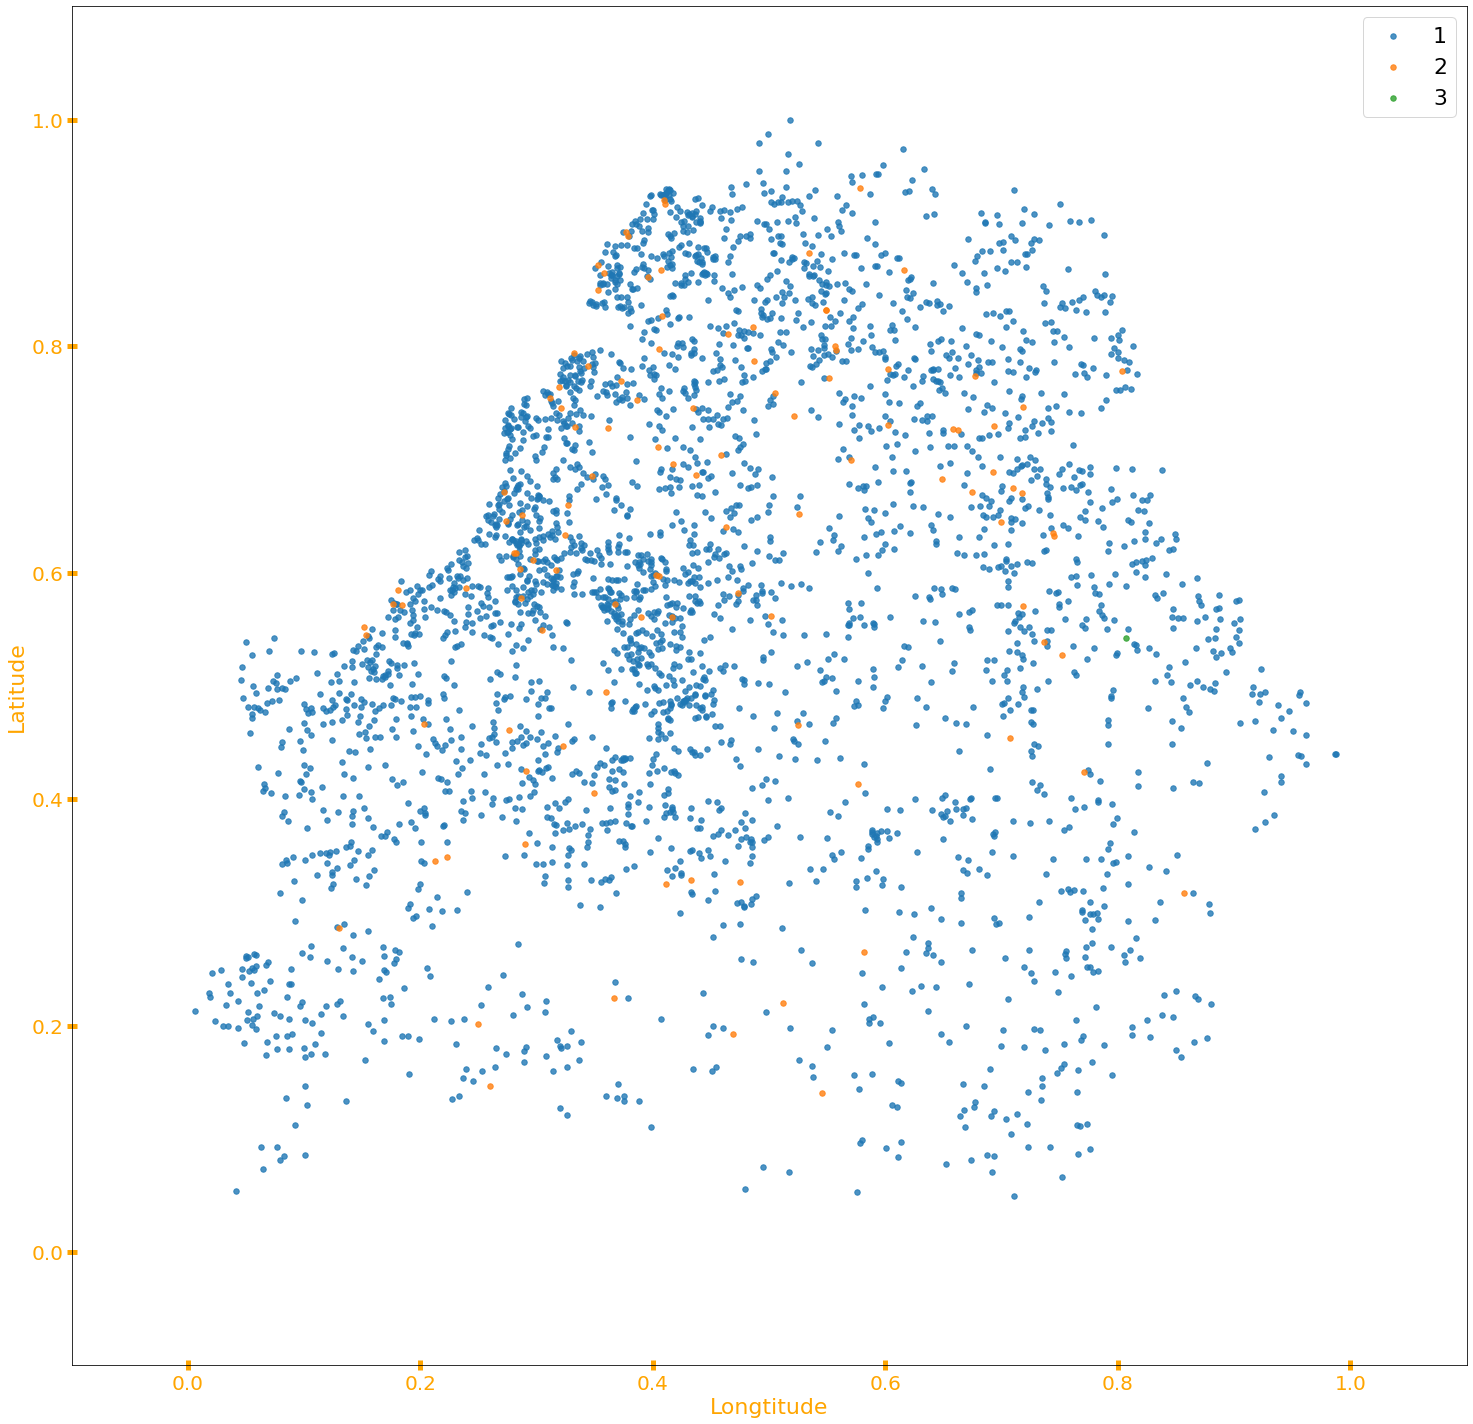

In [236]:
filtered_plot(drawing_data, get_sh, range(1, 20))

### Забавное уплотнение у польских и литовских границ)

### Чисто из любопытства, подробнее глянем, где тот самый город с тремя буковками ш)

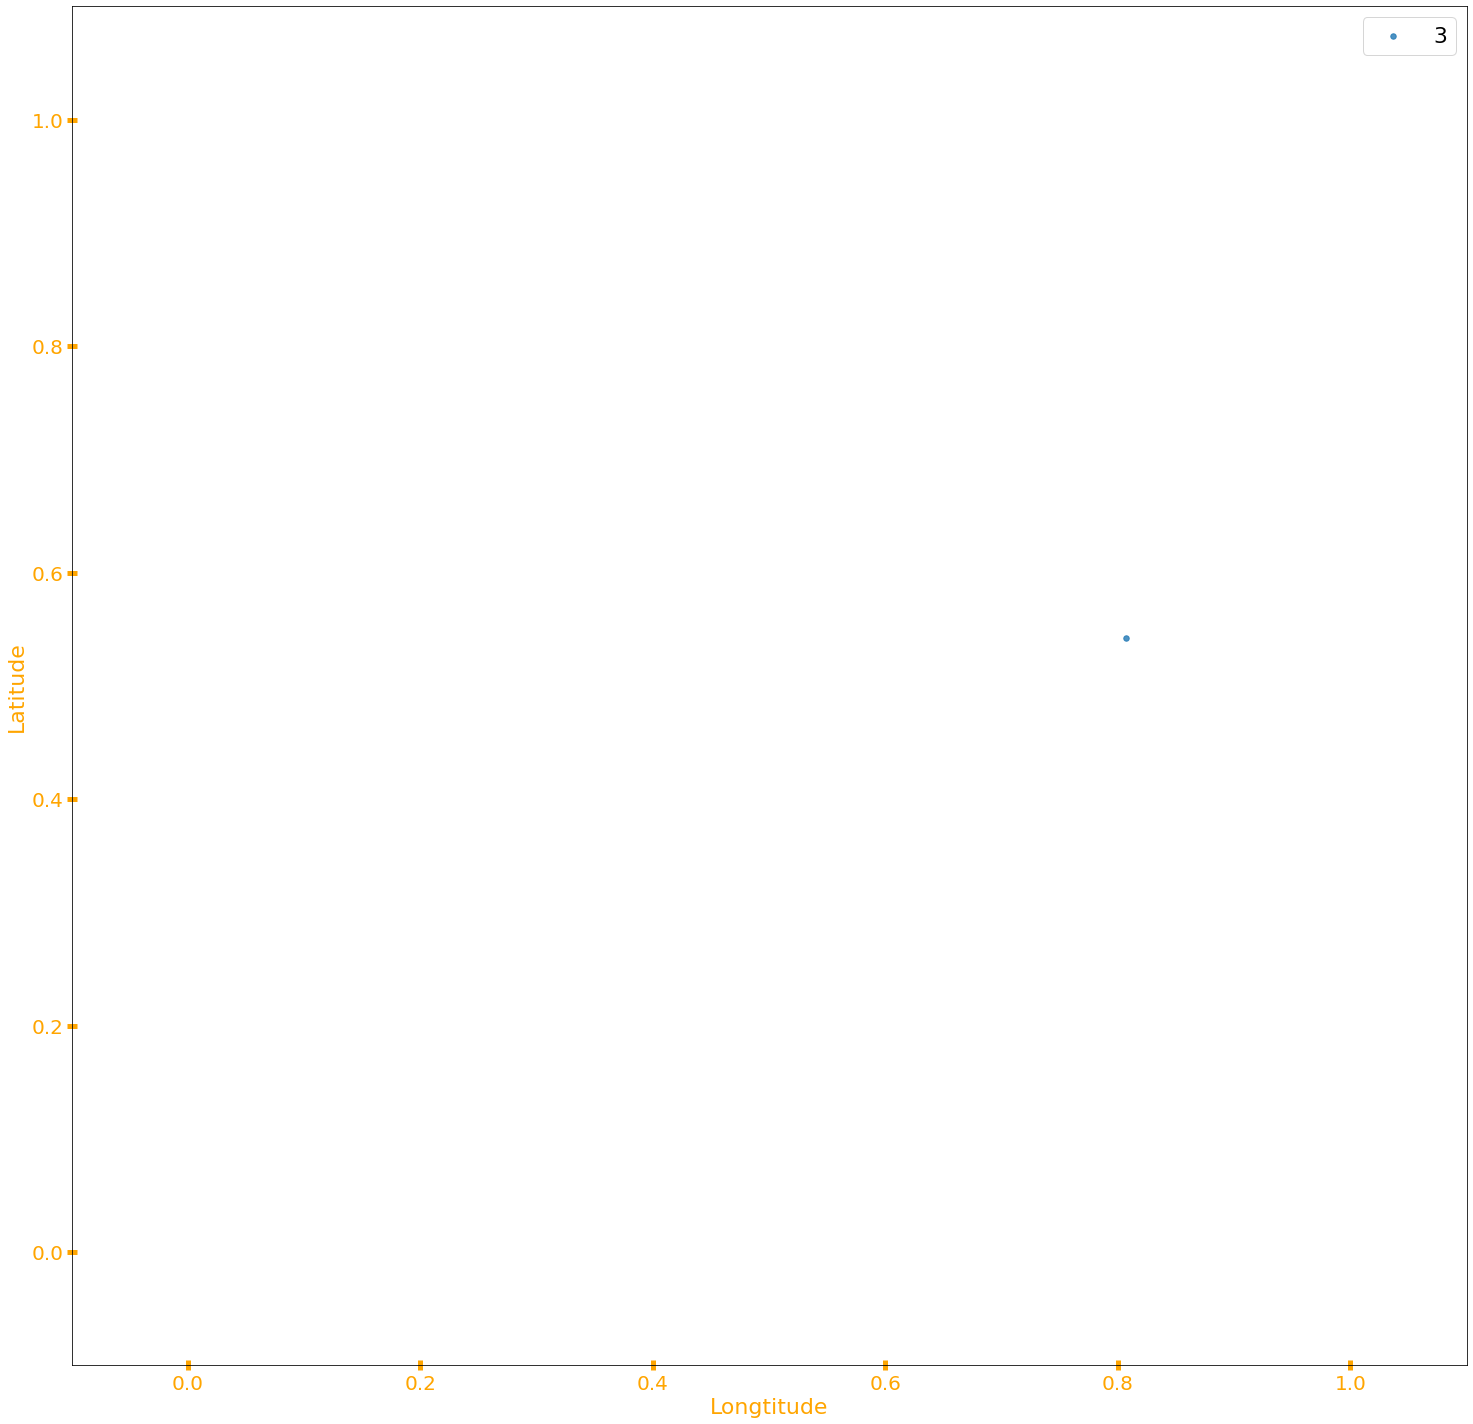

In [237]:
filtered_plot(drawing_data, get_sh, [3])

### Где-то там находится посёлок Зашляшша)

### Давайте ещё ради любопытства построим карту по количеству символов в названии

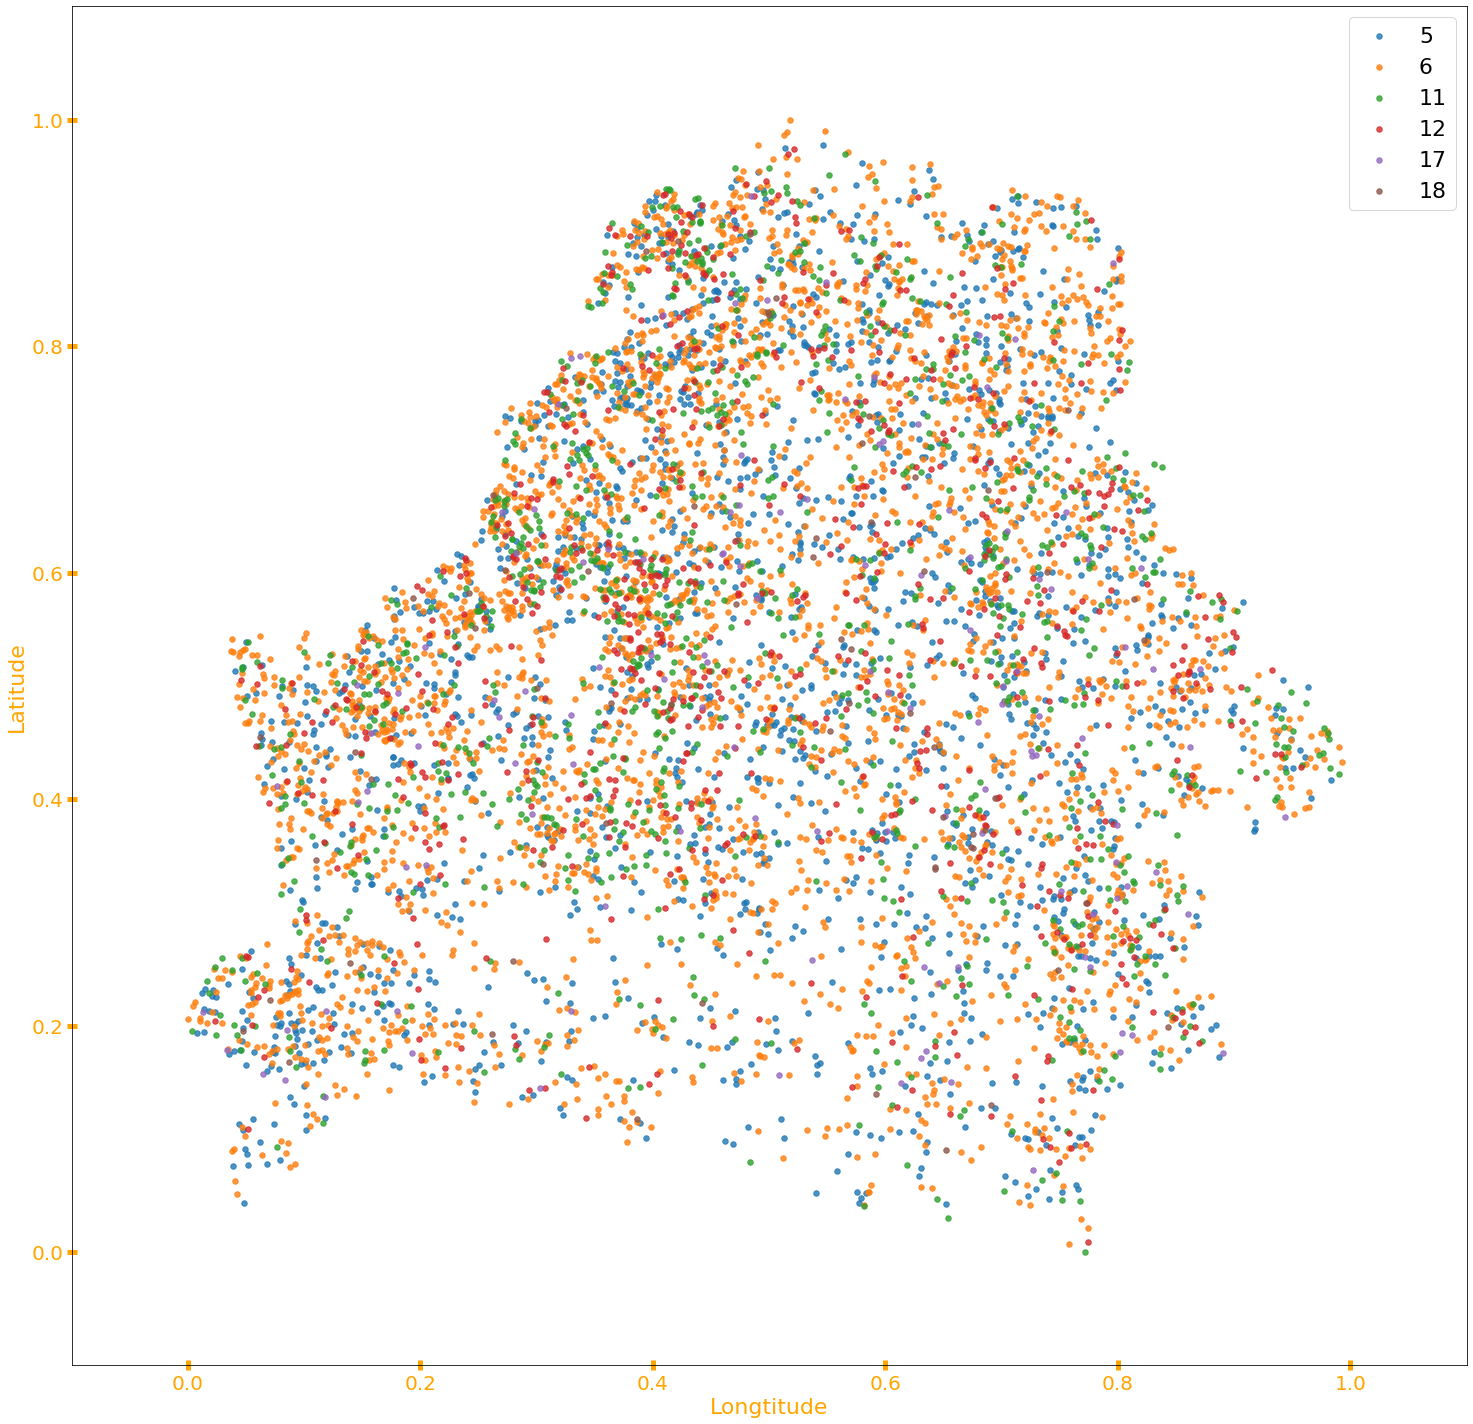

In [238]:
filtered_plot(drawing_data, len, [5,6, 11, 12, 17, 18])

### Ну тут уже совсем сходу можно понять, что ГП и кол-во символов в названии почти независимы. Нет каких-то ярких групп, кроме красно-зелёного скопления к северо-западу от Минска, но думаю, и оно вызвано плотностью поселений в этом регионе.

### Ну и если совсем ~~поехать кукухой~~ нечего делать, можно глянуть на распределение по употреблению букв й и ё.

In [239]:
def count_special_letter_1(word):
    return word.count("й")

def count_special_letter_2(word):
    return word.count("ё")


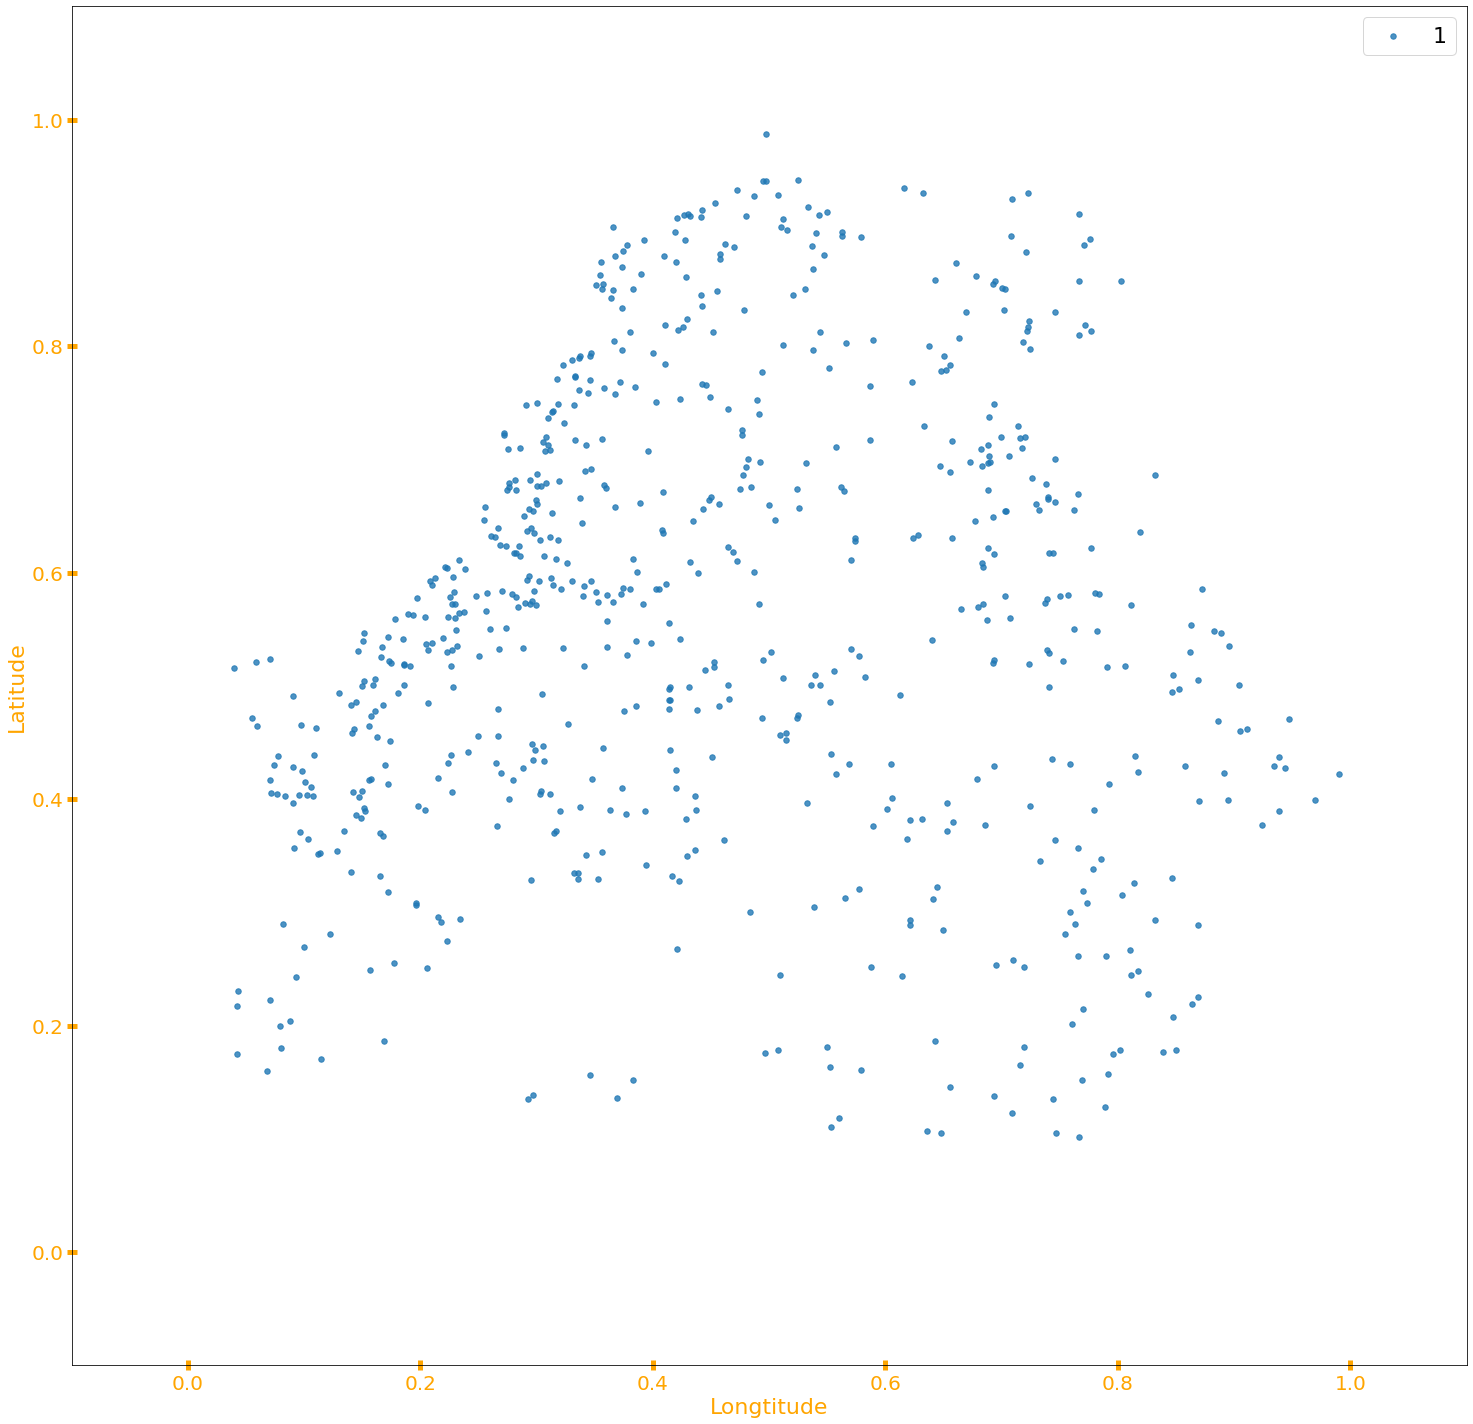

In [240]:
filtered_plot(drawing_data, count_special_letter_1, range(1, 10))

### йокать на границах с Литвой привычнее)

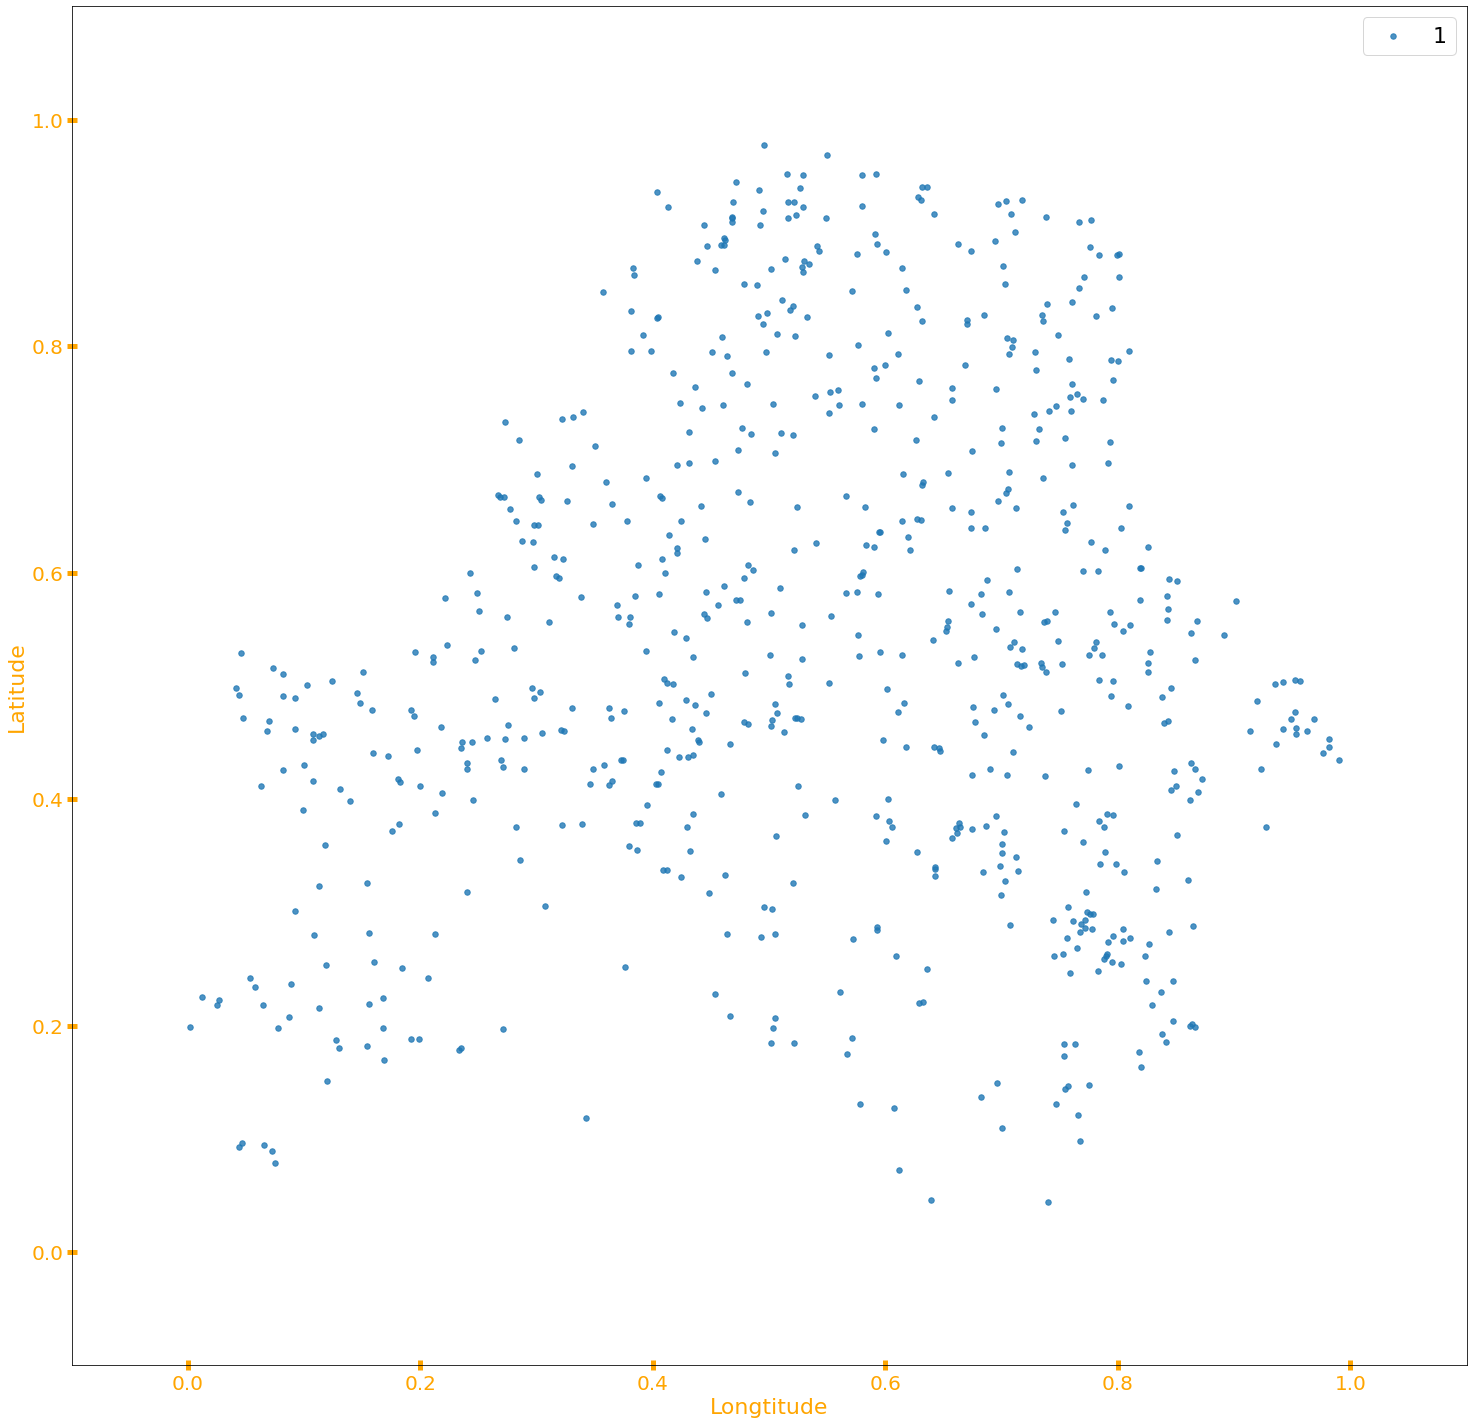

In [241]:
filtered_plot(drawing_data, count_special_letter_2, range(1, 10))

### А ёкать по всей стране любят...Полесье чуть халтурит только...или датасет)

### Давайте проведём все-таки какой-нибудь честный статистический анализ. Вернёмся подробнее к теме окончаний.
### Предлагаю разбить территорию нашей страны на равномерные регионы по долготе и высоте, то есть сделать, скажем,
### 29 отрезочков одинаковой длины (я буду делать только по долготе, можно аналогично и по широте) и посчитать в них количество городов с тем или иным окончанием.
### Естественно, тут может помешать различная плотность городов в регионах, поэтому будем считать "плотность городов с определённым окончанием", а именно: делить на количество всех городов в регионе.
### Это немного странно выглядит...но, видимо, это так в силу простоты и понятности подхода) Вроде бы забавно и здоровью не угрожает, значит, можно попробовать. Пробуем.

In [242]:
number_of_regions = 29
number_of_top_endings = 10
region_markers = np.append(np.arange(0.0, 1.0, 1.0 / number_of_regions), 1.00000001)
regions = [(region_markers[i], region_markers[i + 1]) for i in range(len(region_markers) - 1)]
regions

[(0.0, 0.034482758620689655),
 (0.034482758620689655, 0.06896551724137931),
 (0.06896551724137931, 0.10344827586206896),
 (0.10344827586206896, 0.13793103448275862),
 (0.13793103448275862, 0.1724137931034483),
 (0.1724137931034483, 0.20689655172413793),
 (0.20689655172413793, 0.24137931034482757),
 (0.24137931034482757, 0.27586206896551724),
 (0.27586206896551724, 0.3103448275862069),
 (0.3103448275862069, 0.3448275862068966),
 (0.3448275862068966, 0.3793103448275862),
 (0.3793103448275862, 0.41379310344827586),
 (0.41379310344827586, 0.4482758620689655),
 (0.4482758620689655, 0.48275862068965514),
 (0.48275862068965514, 0.5172413793103449),
 (0.5172413793103449, 0.5517241379310345),
 (0.5517241379310345, 0.5862068965517241),
 (0.5862068965517241, 0.6206896551724138),
 (0.6206896551724138, 0.6551724137931034),
 (0.6551724137931034, 0.6896551724137931),
 (0.6896551724137931, 0.7241379310344828),
 (0.7241379310344828, 0.7586206896551724),
 (0.7586206896551724, 0.7931034482758621),
 (0.79

### Подготовим датафрейм

In [243]:
top_endings = list(blr_endings.keys())[:number_of_top_endings]
regions_data = pd.DataFrame(regions, columns=["left_border", "right_border"])
regions_data[top_endings] = 0.0
regions_data["total"] = 0
regions_data

left_border  right_border   кі   чы   ка   ва   на   цы   ны   ча   ца  \
0      0.000000      0.034483  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.034483      0.068966  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.068966      0.103448  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.103448      0.137931  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.137931      0.172414  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5      0.172414      0.206897  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6      0.206897      0.241379  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7      0.241379      0.275862  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8      0.275862      0.310345  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9      0.310345      0.344828  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10     0.344828      0.379310  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
11     0.379310      0.413793  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
12     0.413793      0.448276  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
13     0.448276      0.482759  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
14     0.482759      0.517241  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15     0.517241      0.551724  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16     0.551724      0.586207  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
17     0.586207      0.620690  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
18     0.620690      0.655172  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
19     0.655172      0.689655  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
20     0.689655      0.724138  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
21     0.724138      0.758621  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
22     0.758621      0.793103  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
23     0.793103      0.827586  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
24     0.827586      0.862069  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
25     0.862069      0.896552  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
26     0.896552      0.931034  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
27     0.931034      0.965517  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
28     0.965517      1.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     ае  total  
0   0.0      0  
1   0.0      0  
2   0.0      0  
3   0.0      0  
4   0.0      0  
5   0.0      0  
6   0.0      0  
7   0.0      0  
8   0.0      0  
9   0.0      0  
10  0.0      0  
11  0.0      0  
12  0.0      0  
13  0.0      0  
14  0.0      0  
15  0.0      0  
16  0.0      0  
17  0.0      0  
18  0.0      0  
19  0.0      0  
20  0.0      0  
21  0.0      0  
22  0.0      0  
23  0.0      0  
24  0.0      0  
25  0.0      0  
26  0.0      0  
27  0.0      0  
28  0.0      0

### Теперь пройдёмся по нашим данным и высчитаем плотность для каждого окончания

In [244]:
for index in data.index:
    ending = get_ending(data.at[index, "blr_name"])
    if ending not in top_endings:
        continue
    longtitude = data.at[index, "scaled_longtitude"]
    regions_data.loc[(regions_data["left_border"] <= longtitude) & (regions_data["right_border"] > longtitude), "total"] += 1
    regions_data.loc[(regions_data["left_border"] <= longtitude) & (regions_data["right_border"] > longtitude), ending] += 1.0
for index in regions_data.index:
    total = regions_data.at[index, "total"]
    for ending_ in top_endings:
        regions_data.at[index, ending_] /= total
regions_data

left_border  right_border        кі        чы        ка        ва  \
0      0.000000      0.034483  0.258065  0.225806  0.112903  0.112903   
1      0.034483      0.068966  0.223443  0.238095  0.131868  0.091575   
2      0.068966      0.103448  0.280269  0.199552  0.076233  0.100897   
3      0.103448      0.137931  0.254364  0.192020  0.067332  0.084788   
4      0.137931      0.172414  0.273913  0.254348  0.082609  0.056522   
5      0.172414      0.206897  0.244292  0.244292  0.089041  0.084475   
6      0.206897      0.241379  0.274775  0.231982  0.040541  0.117117   
7      0.241379      0.275862  0.273942  0.189310  0.102450  0.113586   
8      0.275862      0.310345  0.240642  0.201872  0.073529  0.097594   
9      0.310345      0.344828  0.281570  0.211604  0.064846  0.104096   
10     0.344828      0.379310  0.249664  0.194631  0.063087  0.100671   
11     0.379310      0.413793  0.245958  0.172055  0.081986  0.109700   
12     0.413793      0.448276  0.222892  0.130522  0.123494  0.127510   
13     0.448276      0.482759  0.212411  0.137232  0.120525  0.164678   
14     0.482759      0.517241  0.191395  0.102374  0.143917  0.201780   
15     0.517241      0.551724  0.188742  0.107616  0.142384  0.185430   
16     0.551724      0.586207  0.158070  0.123128  0.183028  0.138103   
17     0.586207      0.620690  0.141566  0.117470  0.212349  0.149096   
18     0.620690      0.655172  0.181090  0.136218  0.213141  0.161859   
19     0.655172      0.689655  0.188218  0.139368  0.191092  0.150862   
20     0.689655      0.724138  0.192308  0.087533  0.184350  0.234748   
21     0.724138      0.758621  0.170915  0.095952  0.211394  0.209895   
22     0.758621      0.793103  0.156495  0.111111  0.272300  0.190923   
23     0.793103      0.827586  0.176471  0.100840  0.283613  0.130252   
24     0.827586      0.862069  0.173759  0.060284  0.368794  0.163121   
25     0.862069      0.896552  0.184358  0.117318  0.273743  0.128492   
26     0.896552      0.931034  0.077670  0.194175  0.339806  0.126214   
27     0.931034      0.965517  0.149123  0.122807  0.535088  0.061404   
28     0.965517      1.000000  0.035714  0.035714  0.750000  0.071429   

          на        цы        ны        ча        ца        ае  total  
0   0.096774  0.064516  0.000000  0.080645  0.032258  0.016129     62  
1   0.058608  0.113553  0.084249  0.018315  0.032967  0.007326    273  
2   0.076233  0.094170  0.100897  0.015695  0.035874  0.020179    446  
3   0.089776  0.159601  0.087282  0.012469  0.037406  0.014963    401  
4   0.076087  0.156522  0.060870  0.010870  0.015217  0.013043    460  
5   0.075342  0.168950  0.052511  0.018265  0.018265  0.004566    438  
6   0.078829  0.105856  0.103604  0.029279  0.015766  0.002252    444  
7   0.115813  0.084633  0.082405  0.013363  0.017817  0.006682    449  
8   0.110963  0.080214  0.131016  0.038770  0.024064  0.001337    748  
9   0.122867  0.056314  0.092150  0.037543  0.015358  0.013652    586  
10  0.173154  0.067114  0.075168  0.033557  0.022819  0.020134    745  
11  0.193995  0.071594  0.062356  0.021940  0.017321  0.023095    866  
12  0.202811  0.077309  0.046185  0.027108  0.019076  0.023092    996  
13  0.130072  0.085919  0.051313  0.053699  0.022673  0.021480    838  
14  0.140950  0.035608  0.028190  0.071217  0.034125  0.050445    674  
15  0.150662  0.056291  0.034768  0.062914  0.031457  0.039735    604  
16  0.134775  0.053245  0.031614  0.084859  0.046589  0.046589    601  
17  0.155120  0.030120  0.037651  0.058735  0.052711  0.045181    664  
18  0.113782  0.038462  0.040064  0.056090  0.035256  0.024038    624  
19  0.120690  0.044540  0.027299  0.067529  0.040230  0.030172    696  
20  0.131300  0.035809  0.034483  0.039788  0.022546  0.037135    754  
21  0.124438  0.041979  0.032984  0.043478  0.028486  0.040480    667  
22  0.111111  0.018779  0.026604  0.062598  0.031299  0.018779    639  
23  0.142857  0.027311  0.054622  0.031513  0.023109  0.029412    476  
24  0.088652 

### Давайте теперь дадим каждому региону среднее значение долготы (ср. арифм.) и высчитаем коэффициент корреляции Пирсона для каждого из окончаний (доля городов с данным окончанием в регионе к средней долготе региона)

In [245]:
regions_data["average_longtitude"] = (regions_data["left_border"] + regions_data["right_border"]) / 2
regions_data

left_border  right_border        кі        чы        ка        ва  \
0      0.000000      0.034483  0.258065  0.225806  0.112903  0.112903   
1      0.034483      0.068966  0.223443  0.238095  0.131868  0.091575   
2      0.068966      0.103448  0.280269  0.199552  0.076233  0.100897   
3      0.103448      0.137931  0.254364  0.192020  0.067332  0.084788   
4      0.137931      0.172414  0.273913  0.254348  0.082609  0.056522   
5      0.172414      0.206897  0.244292  0.244292  0.089041  0.084475   
6      0.206897      0.241379  0.274775  0.231982  0.040541  0.117117   
7      0.241379      0.275862  0.273942  0.189310  0.102450  0.113586   
8      0.275862      0.310345  0.240642  0.201872  0.073529  0.097594   
9      0.310345      0.344828  0.281570  0.211604  0.064846  0.104096   
10     0.344828      0.379310  0.249664  0.194631  0.063087  0.100671   
11     0.379310      0.413793  0.245958  0.172055  0.081986  0.109700   
12     0.413793      0.448276  0.222892  0.130522  0.123494  0.127510   
13     0.448276      0.482759  0.212411  0.137232  0.120525  0.164678   
14     0.482759      0.517241  0.191395  0.102374  0.143917  0.201780   
15     0.517241      0.551724  0.188742  0.107616  0.142384  0.185430   
16     0.551724      0.586207  0.158070  0.123128  0.183028  0.138103   
17     0.586207      0.620690  0.141566  0.117470  0.212349  0.149096   
18     0.620690      0.655172  0.181090  0.136218  0.213141  0.161859   
19     0.655172      0.689655  0.188218  0.139368  0.191092  0.150862   
20     0.689655      0.724138  0.192308  0.087533  0.184350  0.234748   
21     0.724138      0.758621  0.170915  0.095952  0.211394  0.209895   
22     0.758621      0.793103  0.156495  0.111111  0.272300  0.190923   
23     0.793103      0.827586  0.176471  0.100840  0.283613  0.130252   
24     0.827586      0.862069  0.173759  0.060284  0.368794  0.163121   
25     0.862069      0.896552  0.184358  0.117318  0.273743  0.128492   
26     0.896552      0.931034  0.077670  0.194175  0.339806  0.126214   
27     0.931034      0.965517  0.149123  0.122807  0.535088  0.061404   
28     0.965517      1.000000  0.035714  0.035714  0.750000  0.071429   

          на        цы        ны        ча        ца        ае  total  \
0   0.096774  0.064516  0.000000  0.080645  0.032258  0.016129     62   
1   0.058608  0.113553  0.084249  0.018315  0.032967  0.007326    273   
2   0.076233  0.094170  0.100897  0.015695  0.035874  0.020179    446   
3   0.089776  0.159601  0.087282  0.012469  0.037406  0.014963    401   
4   0.076087  0.156522  0.060870  0.010870  0.015217  0.013043    460   
5   0.075342  0.168950  0.052511  0.018265  0.018265  0.004566    438   
6   0.078829  0.105856  0.103604  0.029279  0.015766  0.002252    444   
7   0.115813  0.084633  0.082405  0.013363  0.017817  0.006682    449   
8   0.110963  0.080214  0.131016  0.038770  0.024064  0.001337    748   
9   0.122867  0.056314  0.092150  0.037543  0.015358  0.013652    586   
10  0.173154  0.067114  0.075168  0.033557  0.022819  0.020134    745   
11  0.193995  0.071594  0.062356  0.021940  0.017321  0.023095    866   
12  0.202811  0.077309  0.046185  0.027108  0.019076  0.023092    996   
13  0.130072  0.085919  0.051313  0.053699  0.022673  0.021480    838   
14  0.140950  0.035608  0.028190  0.071217  0.034125  0.050445    674   
15  0.150662  0.056291  0.034768  0.062914  0.031457  0.039735    604   
16  0.134775  0.053245  0.031614  0.084859  0.046589  0.046589    601   
17  0.155120  0.030120  0.037651  0.058735  0.052711  0.045181    664   
18  0.113782  0.038462  0.040064  0.056090  0.035256  0.024038    624   
19  0.120690  0.044540  0.027299  0.067529  0.040230  0.030172    696   
20  0.131300  0.035809  0.034483  0.039788  0.022546  0.037135    754   
21  0.124438  0.041979  0.032984  0.043478  0.028486  0.040480    667   
22  0.111111  0.018779  0.026604  0.062598  0.031299  0.018779    639   
23  0.142857  0.027311  0.054622  0.031513  0.023109  0.02941

In [246]:
beautiful_pirson_table = pd.DataFrame(index=["Коэф. Пирсона"], columns=top_endings)
mean_longtitude = regions_data["average_longtitude"].mean()
for ending_ in top_endings:
    mean_ending = regions_data[ending_].mean()
    sum_nominator = 0.0
    sum_denominator_ending = 0.0
    sum_denominator_longtitude = 0.0
    for index in regions_data.index:
        ending_delta = (regions_data.at[index, ending_] - mean_ending)
        longtitude_delta = (regions_data.at[index, "average_longtitude"] - mean_longtitude)
        sum_nominator += ending_delta * longtitude_delta
        sum_denominator_ending += ending_delta * ending_delta
        sum_denominator_longtitude += longtitude_delta * longtitude_delta
    beautiful_pirson_table.at["Коэф. Пирсона", ending_] = sum_nominator / np.sqrt(sum_denominator_ending * sum_denominator_longtitude)
beautiful_pirson_table

кі       чы        ка        ва        на        цы  \
Коэф. Пирсона -0.84751 -0.81357  0.792674  0.372709  0.169812 -0.829409   

                     ны        ча        ца        ае  
Коэф. Пирсона -0.611021  0.156616 -0.206303  0.511285

 ### На мой взгляд визульное впечатление для некоторых окончаний (у которых по модулю более 0.7) неплохо так оправдалось с точки зрения очень грубой и странноватой статистической модели :) Получаем, что для действительно распространённых окончаний городов ki, чы, ка имеет место достаточно сильная корреляция с их долготой. Хотя, как мы видим, это справедливо не для всех позиций.......ну или надо было бы отдельно рассмотреть по широте зависимость, но этого я делать пока не буду. Давайте я просто приведу отдельные карты для самых выдающихся окончаний (по долготе).

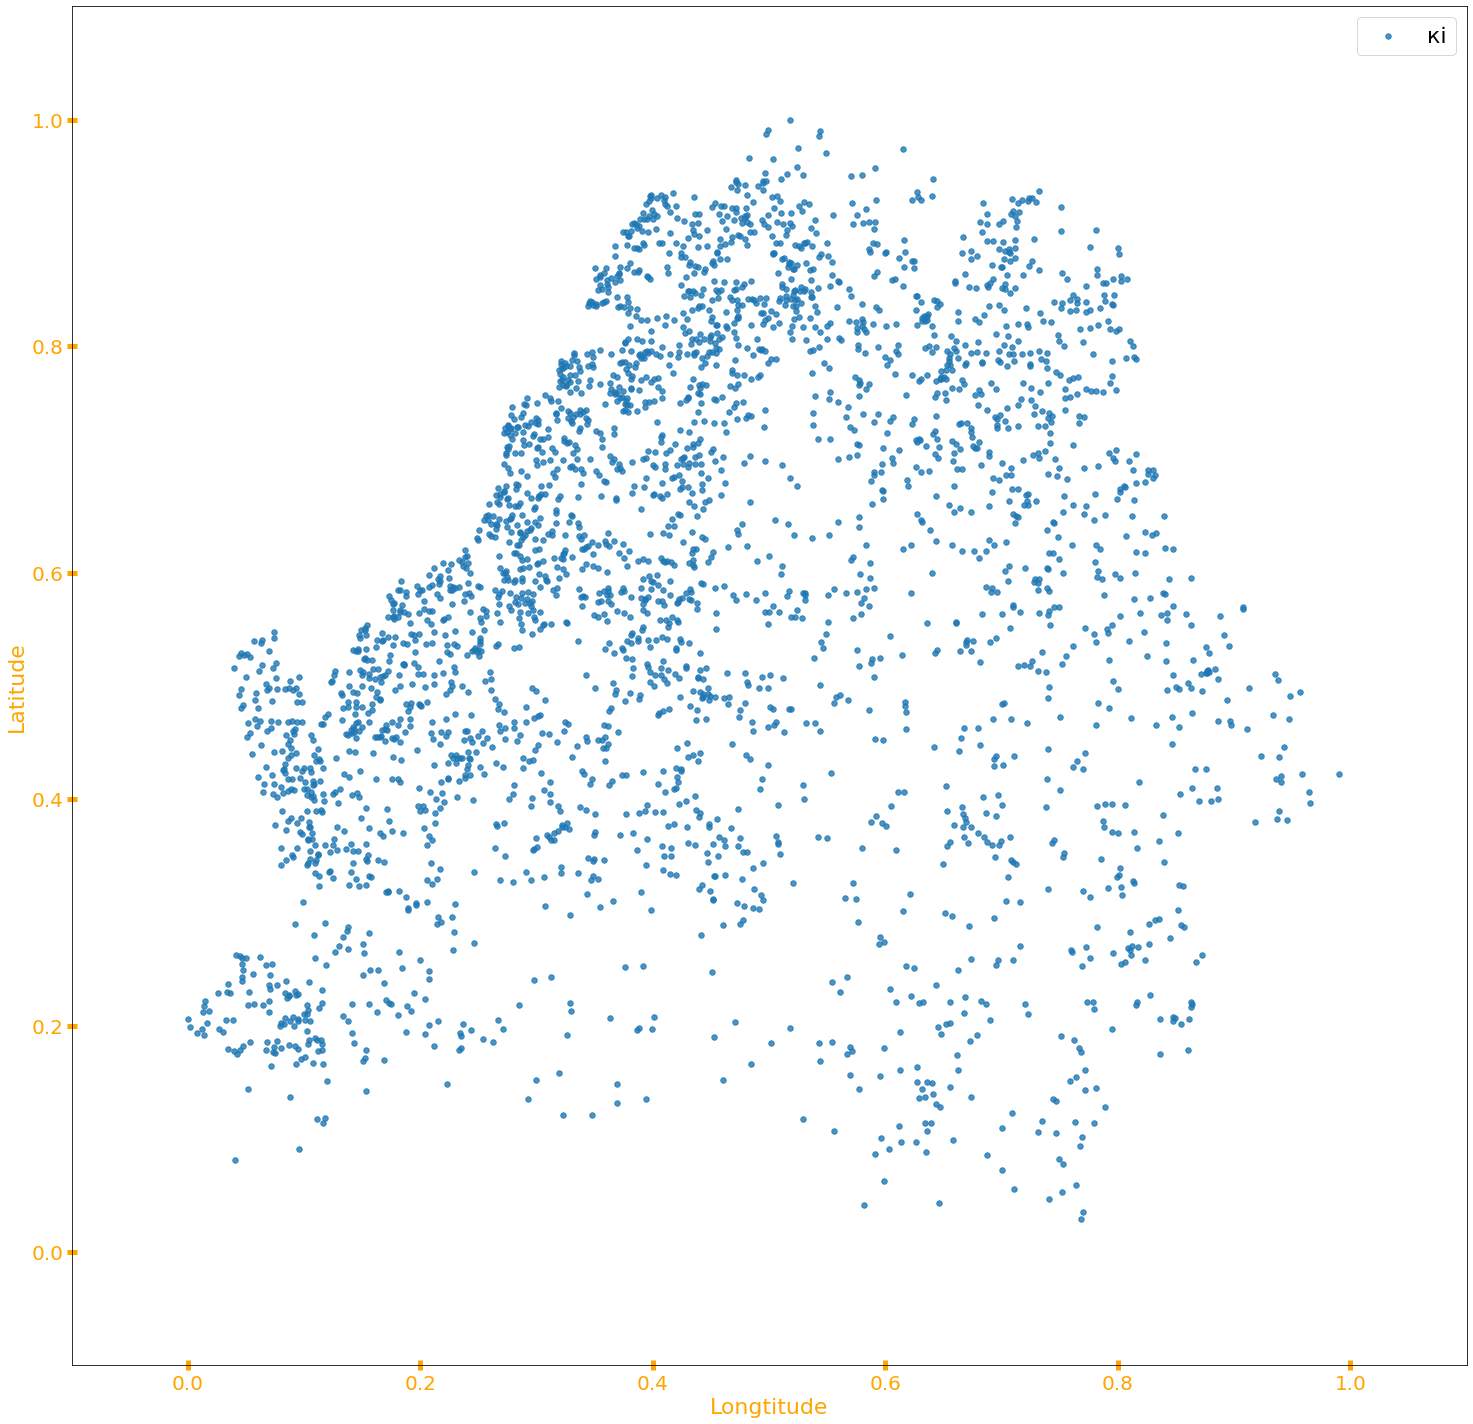

In [247]:
filtered_plot(drawing_data, get_ending, ["кі"])

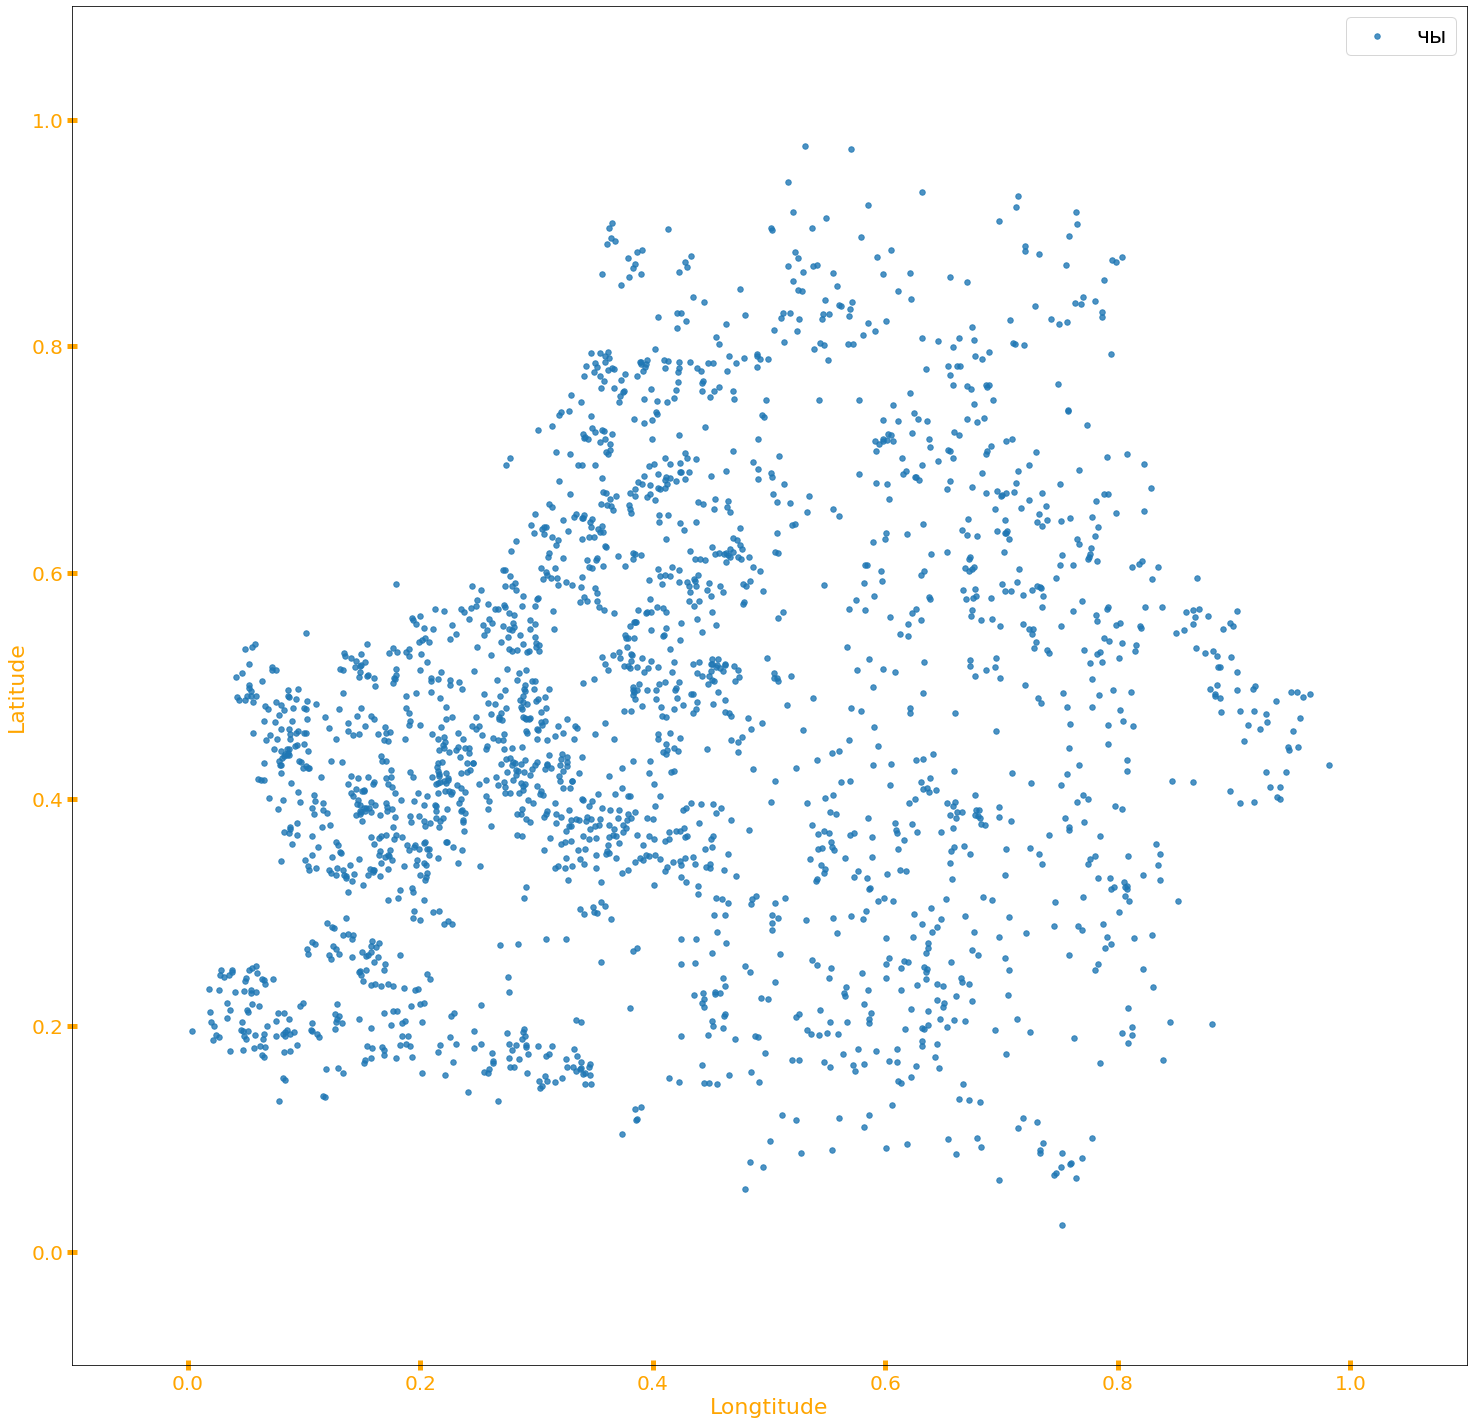

In [248]:
filtered_plot(drawing_data, get_ending, ["чы"])

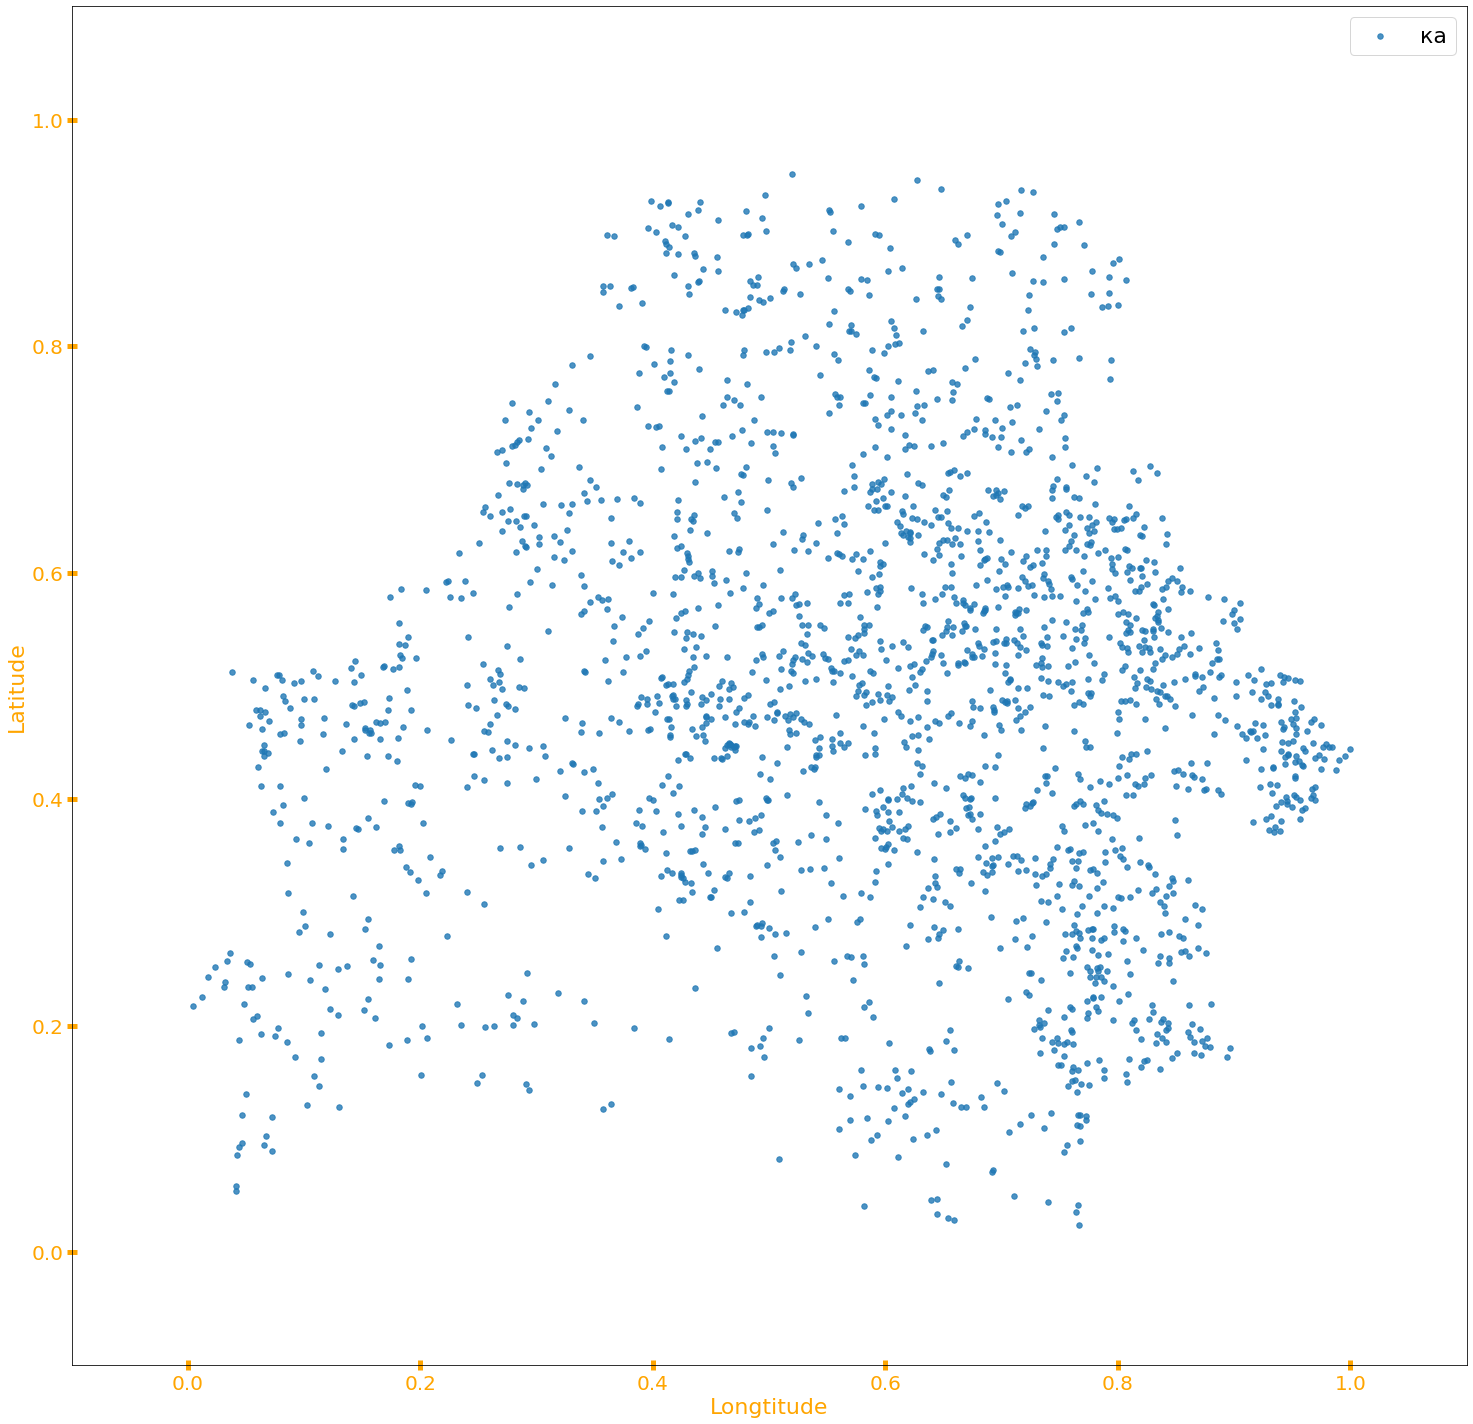

In [249]:
filtered_plot(drawing_data, get_ending, ["ка"])

### Давайте ещё подробнее взглянем на какое-нибудь равномерное распределение, скажем, "ча" (~0.15 по Пирсону)

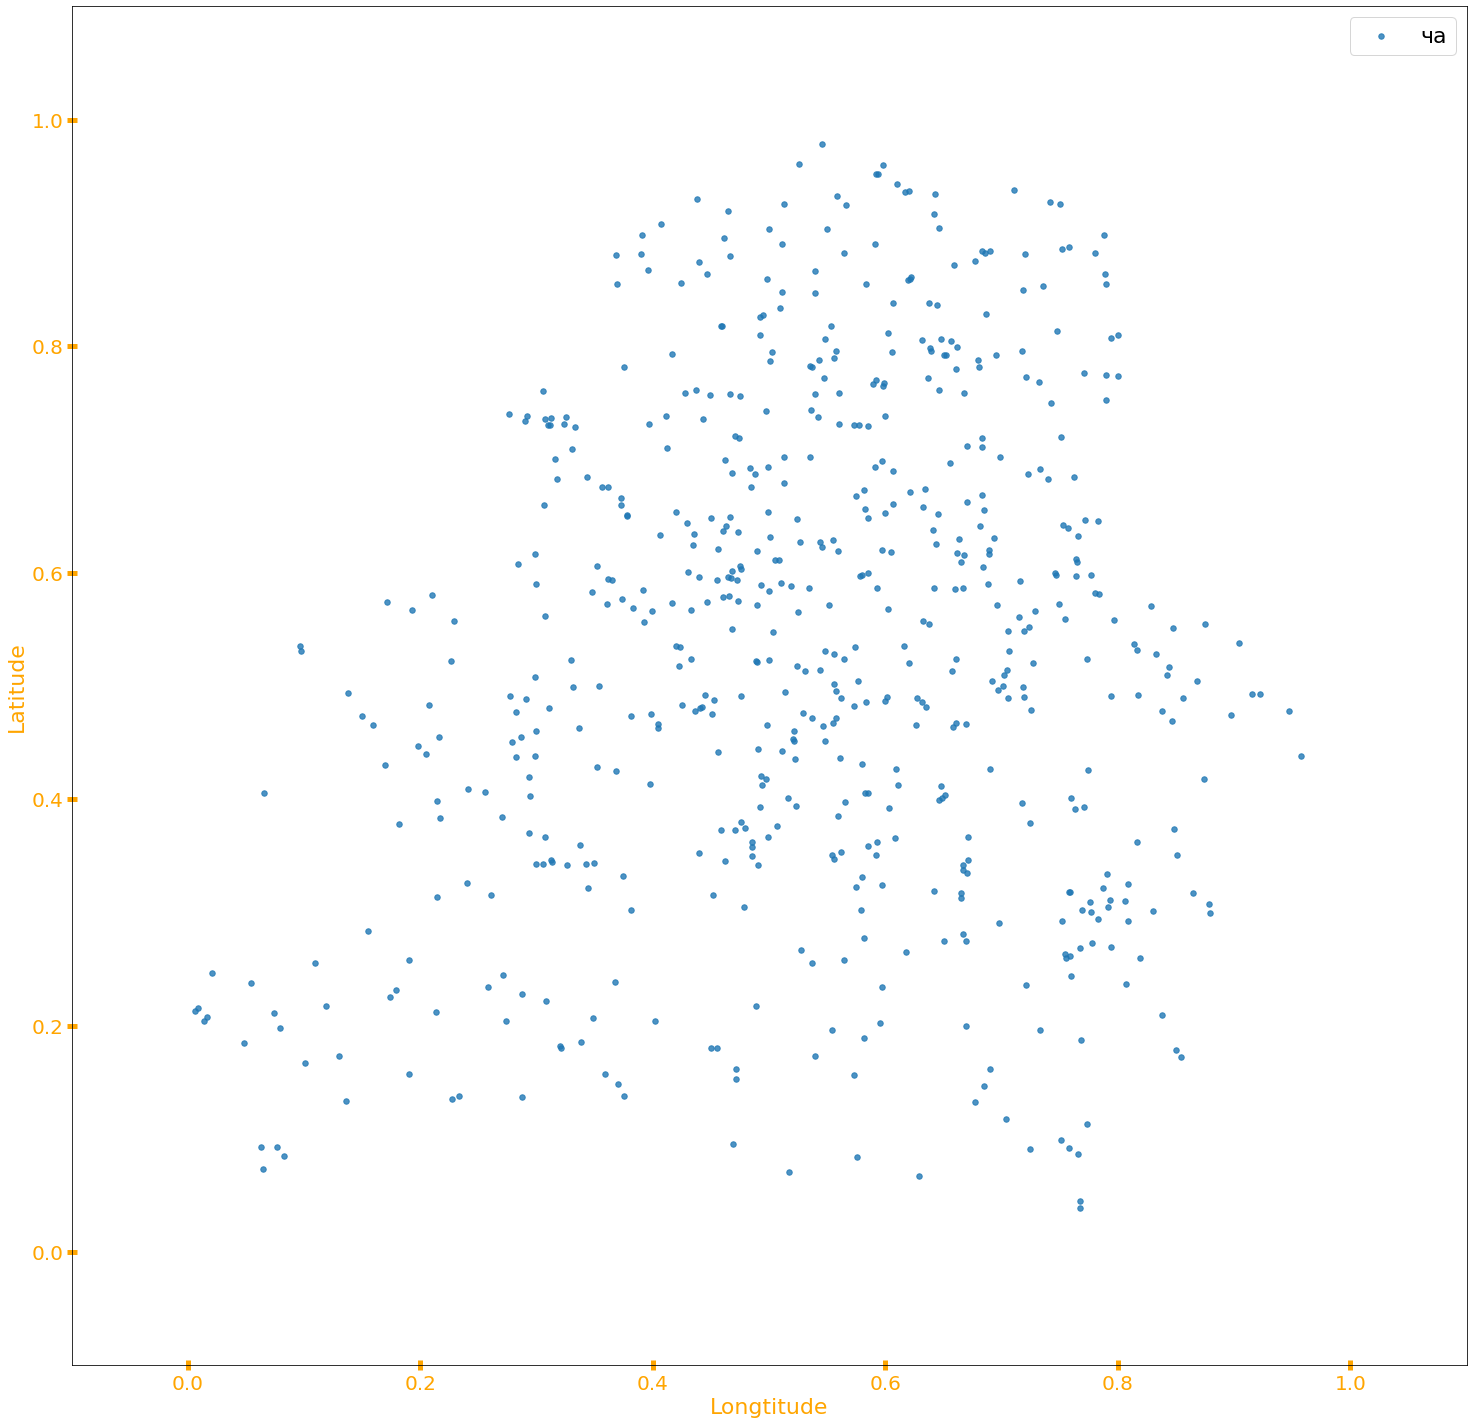

In [250]:
filtered_plot(drawing_data, get_ending, ["ча"])

### Тут уже, в отличие от предыдущих карт сразу наблюдается почти равномерное распределение городов.

### Многие их этих результатов достаточно просто объясняются историческими фактами, но теперь я, например, смогу действительно подтвердить, что такая зависимость существует, а не отговорится чем-то аля "в началке мне сказали". Мне кажется, что мне удалось статистически подтвердить существование зависимости между географическим положением населённых пунктов Беларуси и их названием.

### Схожие штуки можно провернуть и по остальным параметрам (с которыми мы баловались на картах выше), но у меня пока на этом всё)

# Спасибо за внимание!